In [1]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import math
import scipy.stats as stats
import itertools

In [2]:
# Load SMDR stock dataset
df_smdr = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='SMDR.JK')
df_smdr.set_index('Date', drop=True, inplace=True)
df_smdr.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,38000000,38750000,38000000,38000000,19600687,500000
2011-04-04,38750000,38750000,38000000,38750000,19987543,650000
2011-04-05,39750000,40000000,39000000,39750000,20503349,3900000
2011-04-06,41250000,41250000,39750000,41250000,21277061,2100000
2011-04-07,40500000,40500000,40500000,40500000,20890205,1000000


In [3]:
# Check datatypes
print(df_smdr.dtypes)

Open         int64
High         int64
Low          int64
Close        int64
Adj Close    int64
Volume       int64
dtype: object


In [4]:
# Check missing value
print(df_smdr.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


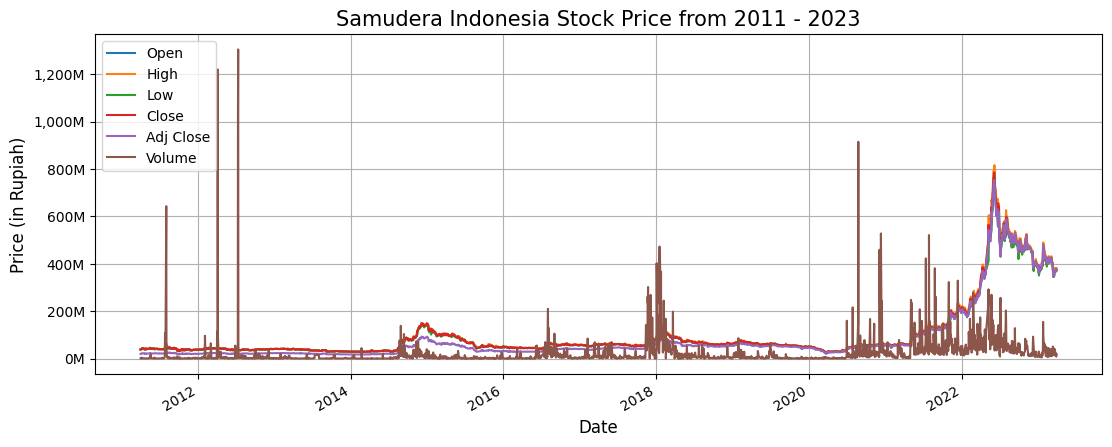

In [5]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_smdr.plot(figsize=(13,5))
plt.title('Samudera Indonesia Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [6]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_smdr[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [7]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.07284768]
 [0.07639546]
 [0.08112583]
 [0.08822138]
 [0.0846736 ]] 

Testing Scaled:  [[0.87228004]
 [0.83916746]
 [0.82970672]
 [0.8013245 ]
 [0.82970672]]


In [8]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [9]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 4s 56ms/step - loss: 0.0061 - val_loss: 0.0175
Epoch 2/10
24/24 [==============================] - 1s 25ms/step - loss: 7.3122e-04 - val_loss: 0.0119
Epoch 3/10
24/24 [==============================] - 1s 25ms/step - loss: 6.1159e-04 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 1s 25ms/step - loss: 5.1559e-04 - val_loss: 0.0041
Epoch 5/10
24/24 [==============================] - 1s 23ms/step - loss: 4.3729e-04 - val_loss: 0.0036
Epoch 6/10
24/24 [==============================] - 1s 23ms/step - loss: 4.1272e-04 - val_loss: 0.0043
Epoch 7/10
24/24 [==============================] - 1s 23ms/step - loss: 3.8141e-04 - val_loss: 0.0022
Epoch 8/10
24/24 [==============================] - 1s 27ms/step - loss: 3.7427e-04 - val_loss: 0.0034
Epoch 9/10
24/24 [==============================] - 1s 25ms/step - loss: 3.3696e-04 - val_loss: 0.0022
Epoch 10/10
24/24 [==============================] - 1s 25ms/step - loss: 3.3

In [10]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 1s 6ms/step
Mean Absolute Error (MAE): 0.6891372
Mean Absolute Percentage Error (MAPE): 0.30152
Root Mean Squared Error (RMSE): 0.77972
Mean Squared Error (MSE): 0.607971
R-Squared (R2): -2.377048
T-Statistic 0.9644
P-Value 1.1670850653899834e-05
Elapsed Time (min): 10.15


7/7 [==============================] - 0s 6ms/step


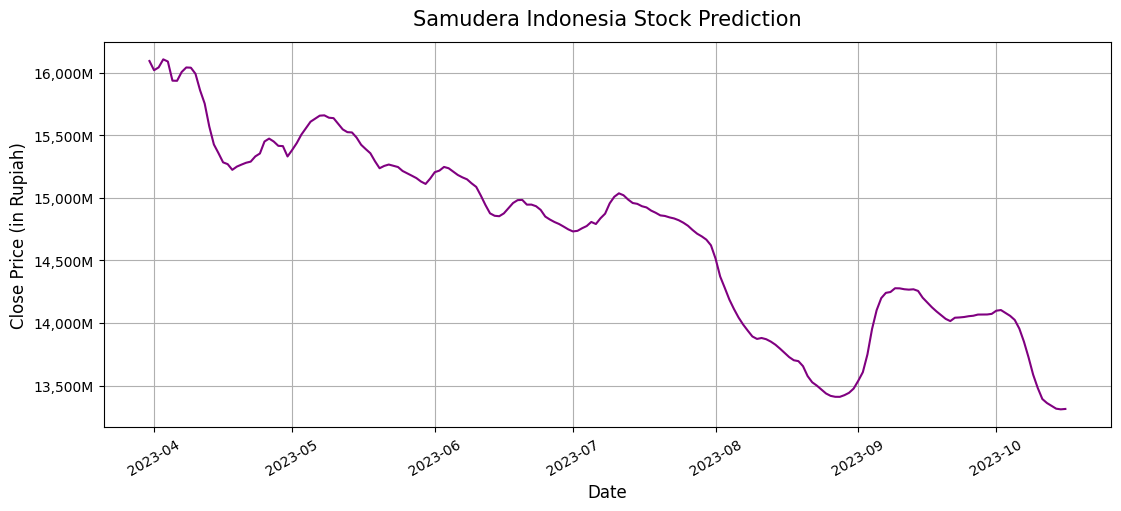

In [11]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [12]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 15s 261ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 2/10
24/24 [==============================] - 7s 311ms/step - loss: 7.5817e-04 - val_loss: 0.0045
Epoch 3/10
24/24 [==============================] - 8s 331ms/step - loss: 5.4590e-04 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 8s 325ms/step - loss: 4.7343e-04 - val_loss: 0.0027
Epoch 5/10
24/24 [==============================] - 8s 317ms/step - loss: 4.6101e-04 - val_loss: 0.0022
Epoch 6/10
24/24 [==============================] - 9s 360ms/step - loss: 3.8857e-04 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 9s 359ms/step - loss: 4.1341e-04 - val_loss: 0.0024
Epoch 8/10
24/24 [==============================] - 9s 374ms/step - loss: 3.6474e-04 - val_loss: 0.0035
Epoch 9/10
24/24 [==============================] - 9s 362ms/step - loss: 3.8277e-04 - val_loss: 0.0022
Epoch 10/10
24/24 [==============================] - 9s 361ms/step 

In [13]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Error (MAE): 0.2800096
Mean Absolute Percentage Error (MAPE): 0.12416
Root Mean Squared Error (RMSE): 0.33146
Mean Squared Error (MSE): 0.1098653
R-Squared (R2): 0.38974
T-Statistic 0.9142
P-Value 1.815296385432319e-10
Elapsed Time (min): 89.82


7/7 [==============================] - 0s 41ms/step


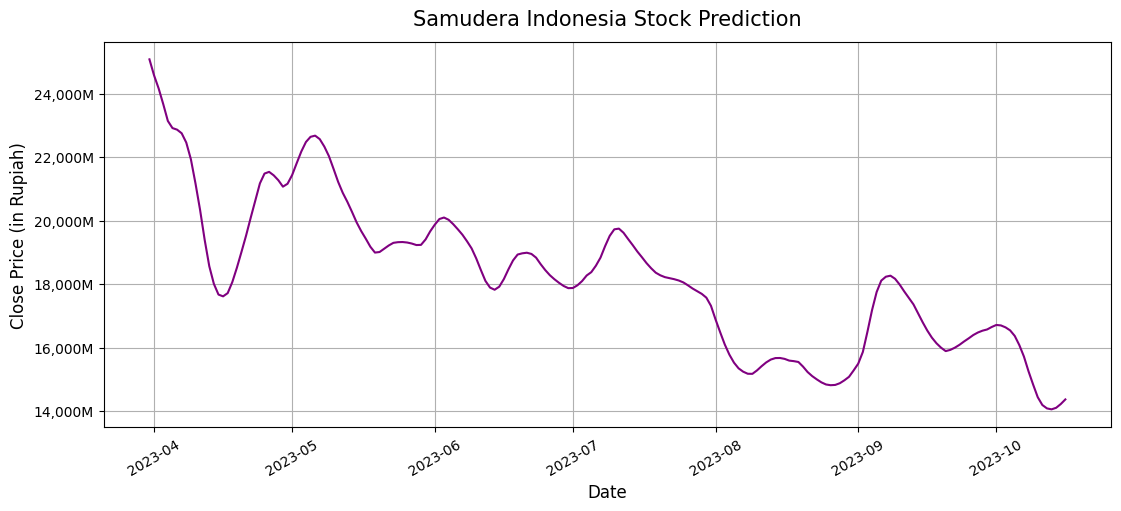

In [14]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [15]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 14s 338ms/step - loss: 0.0197 - val_loss: 0.1659
Epoch 2/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0111 - val_loss: 0.1414
Epoch 3/10
24/24 [==============================] - 8s 352ms/step - loss: 0.0101 - val_loss: 0.1320
Epoch 4/10
24/24 [==============================] - 8s 355ms/step - loss: 0.0096 - val_loss: 0.1271
Epoch 5/10
24/24 [==============================] - 8s 345ms/step - loss: 0.0093 - val_loss: 0.1236
Epoch 6/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0094 - val_loss: 0.1211
Epoch 7/10
24/24 [==============================] - 9s 357ms/step - loss: 0.0092 - val_loss: 0.1190
Epoch 8/10
24/24 [==============================] - 8s 342ms/step - loss: 0.0088 - val_loss: 0.1163
Epoch 9/10
24/24 [==============================] - 8s 355ms/step - loss: 0.0088 - val_loss: 0.1143
Epoch 10/10
24/24 [==============================] - 8s 343ms/step - loss: 0.0087 - val_loss: 0.111

In [16]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 32ms/step
Mean Absolute Error (MAE): 1.8465863
Mean Absolute Percentage Error (MAPE): 0.8513
Root Mean Squared Error (RMSE): 1.89412
Mean Squared Error (MSE): 3.5877094
R-Squared (R2): -18.928362
T-Statistic 0.9167
P-Value 2.79463202579322e-10
Elapsed Time (min): 91.07


7/7 [==============================] - 0s 32ms/step


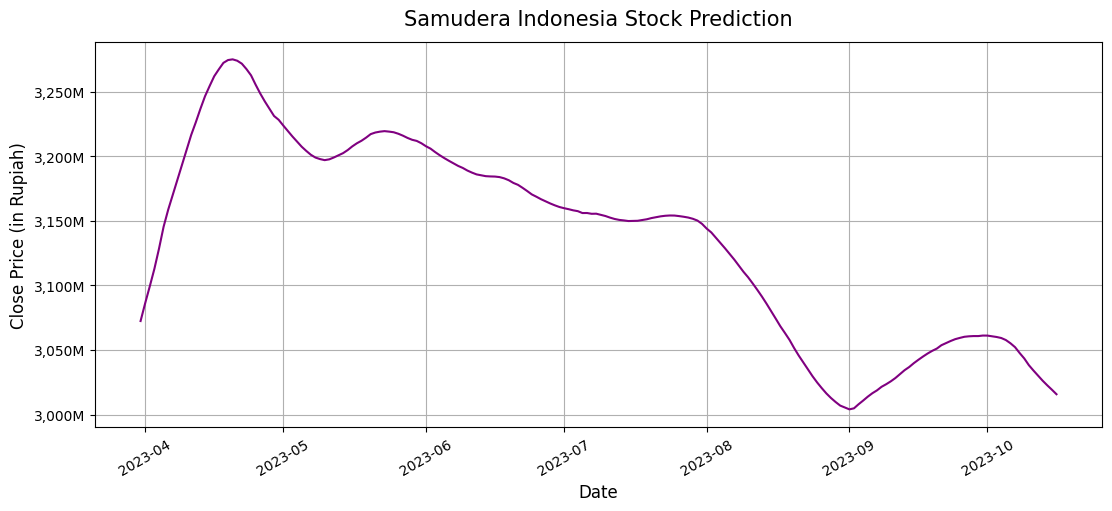

In [17]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [18]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 21s 575ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 2/10
24/24 [==============================] - 12s 501ms/step - loss: 7.1419e-04 - val_loss: 0.0024
Epoch 3/10
24/24 [==============================] - 12s 480ms/step - loss: 5.9377e-04 - val_loss: 0.0051
Epoch 4/10
24/24 [==============================] - 13s 552ms/step - loss: 5.0277e-04 - val_loss: 0.0034
Epoch 5/10
24/24 [==============================] - 13s 550ms/step - loss: 4.8989e-04 - val_loss: 0.0023
Epoch 6/10
24/24 [==============================] - 14s 603ms/step - loss: 4.7183e-04 - val_loss: 0.0035
Epoch 7/10
24/24 [==============================] - 13s 556ms/step - loss: 4.3016e-04 - val_loss: 0.0025
Epoch 8/10
24/24 [==============================] - 12s 506ms/step - loss: 3.8646e-04 - val_loss: 0.0020
Epoch 9/10
24/24 [==============================] - 12s 496ms/step - loss: 3.8298e-04 - val_loss: 0.0020
Epoch 10/10
24/24 [==============================] - 12s 51

In [19]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Error (MAE): 0.3781864
Mean Absolute Percentage Error (MAPE): 0.16957
Root Mean Squared Error (RMSE): 0.42432
Mean Squared Error (MSE): 0.1800447
R-Squared (R2): -8e-05
T-Statistic 0.9072
P-Value 5.530911145745776e-11
Elapsed Time (min): 136.34


7/7 [==============================] - 0s 40ms/step


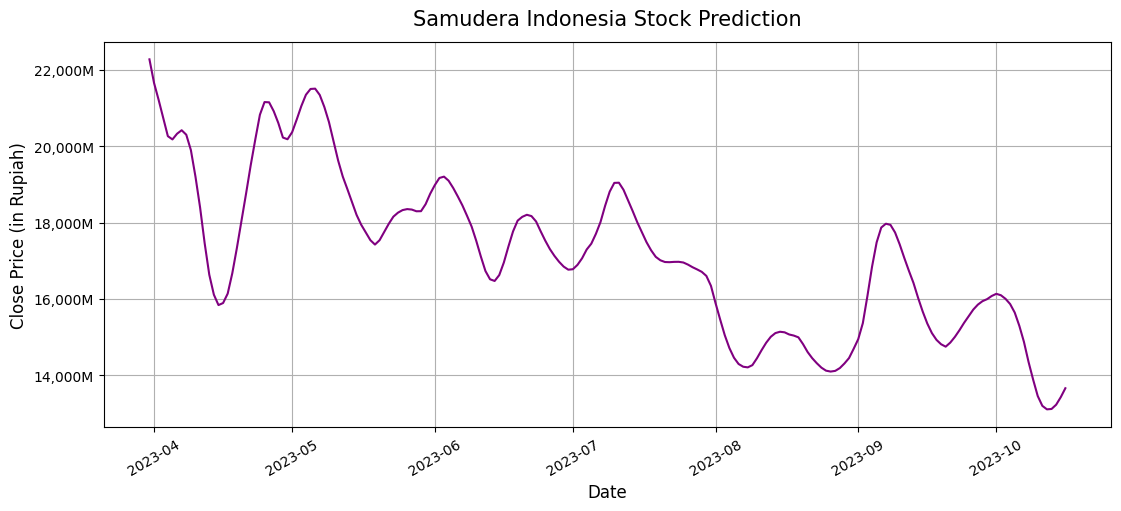

In [20]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [21]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 19s 512ms/step - loss: 0.0036 - val_loss: 0.0059
Epoch 2/10
24/24 [==============================] - 10s 411ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 3/10
24/24 [==============================] - 10s 426ms/step - loss: 0.0011 - val_loss: 0.0110
Epoch 4/10
24/24 [==============================] - 10s 407ms/step - loss: 0.0011 - val_loss: 0.0092
Epoch 5/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0010 - val_loss: 0.0068
Epoch 6/10
24/24 [==============================] - 11s 449ms/step - loss: 9.2701e-04 - val_loss: 0.0064
Epoch 7/10
24/24 [==============================] - 10s 432ms/step - loss: 7.7841e-04 - val_loss: 0.0025
Epoch 8/10
24/24 [==============================] - 10s 419ms/step - loss: 9.1408e-04 - val_loss: 0.0034
Epoch 9/10
24/24 [==============================] - 10s 413ms/step - loss: 6.7643e-04 - val_loss: 0.0020
Epoch 10/10
24/24 [==============================] - 10s 409ms/step - loss:

In [22]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.3444461
Mean Absolute Percentage Error (MAPE): 0.14917
Root Mean Squared Error (RMSE): 0.41862
Mean Squared Error (MSE): 0.175245
R-Squared (R2): 0.02658
T-Statistic 0.9538
P-Value 6.681451054646459e-07
Elapsed Time (min): 111.17


7/7 [==============================] - 0s 40ms/step


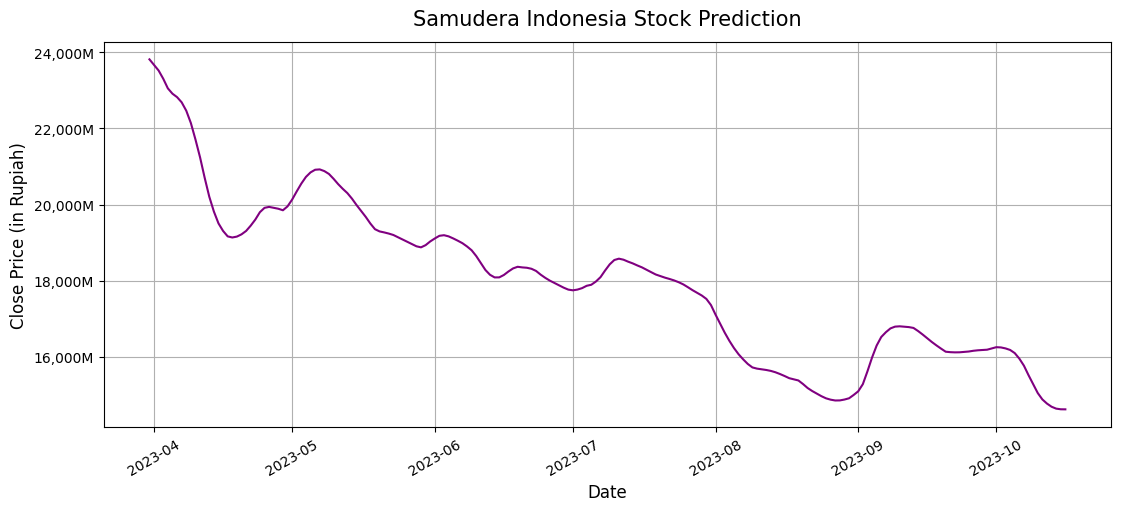

In [23]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [24]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 20s 482ms/step - loss: 0.0277 - val_loss: 0.2075
Epoch 2/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0273 - val_loss: 0.2054
Epoch 3/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0268 - val_loss: 0.2033
Epoch 4/10
24/24 [==============================] - 10s 419ms/step - loss: 0.0264 - val_loss: 0.2011
Epoch 5/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0259 - val_loss: 0.1990
Epoch 6/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0256 - val_loss: 0.1968
Epoch 7/10
24/24 [==============================] - 10s 435ms/step - loss: 0.0250 - val_loss: 0.1946
Epoch 8/10
24/24 [==============================] - 11s 443ms/step - loss: 0.0245 - val_loss: 0.1924
Epoch 9/10
24/24 [==============================] - 10s 432ms/step - loss: 0.0240 - val_loss: 0.1903
Epoch 10/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0236 - val_lo

In [25]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 1.9216183
Mean Absolute Percentage Error (MAPE): 0.8891
Root Mean Squared Error (RMSE): 1.96277
Mean Squared Error (MSE): 3.8524586
R-Squared (R2): -20.398944
T-Statistic 0.9673
P-Value 2.785374272207264e-05
Elapsed Time (min): 114.54


7/7 [==============================] - 0s 39ms/step


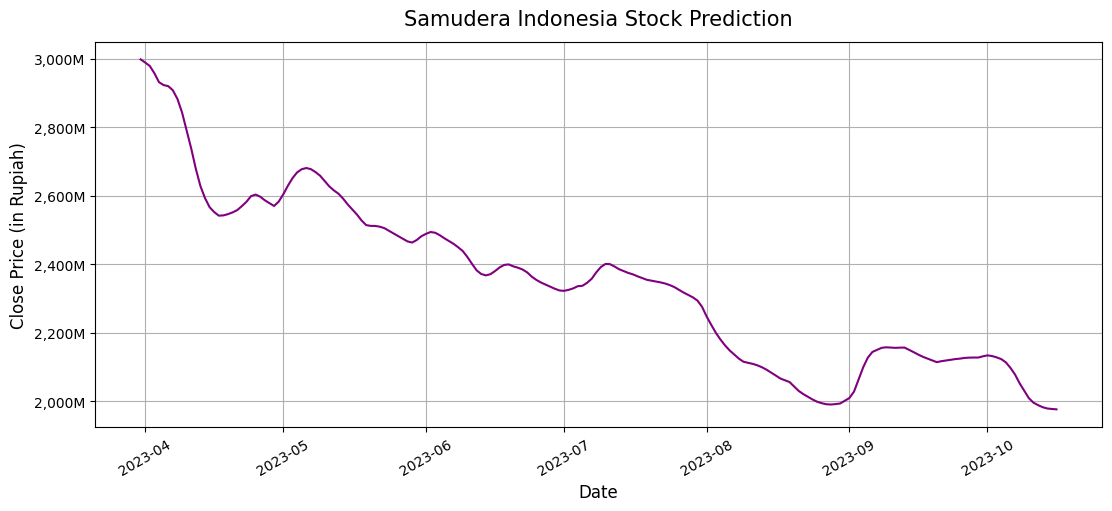

In [26]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [27]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 24s 730ms/step - loss: 0.0111 - val_loss: 0.1081
Epoch 2/10
24/24 [==============================] - 15s 629ms/step - loss: 0.0080 - val_loss: 0.1036
Epoch 3/10
24/24 [==============================] - 15s 622ms/step - loss: 0.0076 - val_loss: 0.0975
Epoch 4/10
24/24 [==============================] - 15s 616ms/step - loss: 0.0071 - val_loss: 0.0935
Epoch 5/10
24/24 [==============================] - 15s 630ms/step - loss: 0.0068 - val_loss: 0.0869
Epoch 6/10
24/24 [==============================] - 15s 612ms/step - loss: 0.0065 - val_loss: 0.0811
Epoch 7/10
24/24 [==============================] - 15s 625ms/step - loss: 0.0059 - val_loss: 0.0760
Epoch 8/10
24/24 [==============================] - 17s 695ms/step - loss: 0.0058 - val_loss: 0.0713
Epoch 9/10
24/24 [==============================] - 15s 638ms/step - loss: 0.0053 - val_loss: 0.0677
Epoch 10/10
24/24 [==============================] - 15s 643ms/step - loss: 0.0050 - val_lo

In [28]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 1.4224792
Mean Absolute Percentage Error (MAPE): 0.65211
Root Mean Squared Error (RMSE): 1.47137
Mean Squared Error (MSE): 2.1649186
R-Squared (R2): -11.0253
T-Statistic 0.9797
P-Value 0.0017343525541946292
Elapsed Time (min): 161.77


7/7 [==============================] - 0s 43ms/step


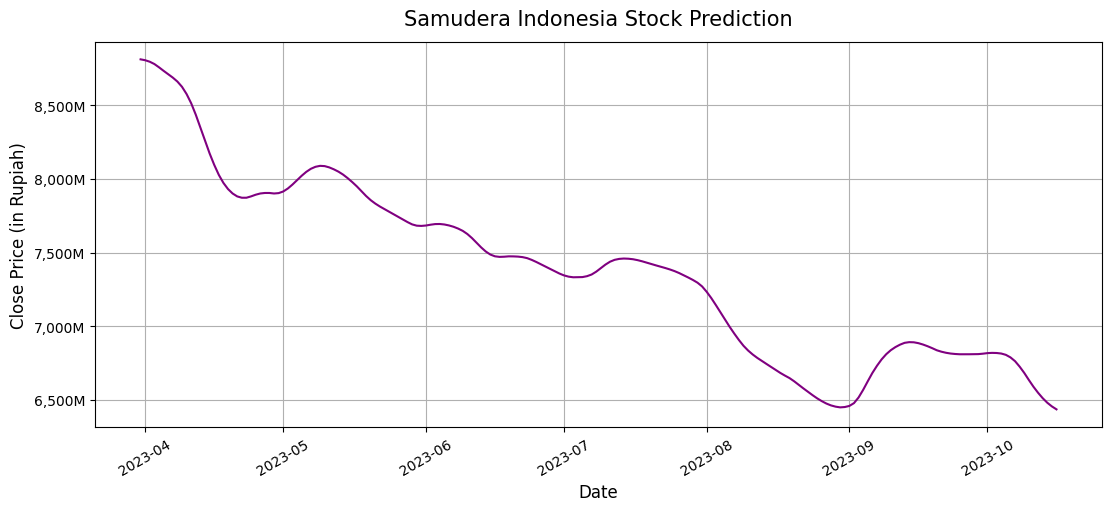

In [29]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [30]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 23s 631ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 2/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0010 - val_loss: 0.0036
Epoch 3/10
24/24 [==============================] - 11s 458ms/step - loss: 8.7702e-04 - val_loss: 0.0032
Epoch 4/10
24/24 [==============================] - 11s 452ms/step - loss: 8.0272e-04 - val_loss: 0.0030
Epoch 5/10
24/24 [==============================] - 11s 459ms/step - loss: 7.8517e-04 - val_loss: 0.0033
Epoch 6/10
24/24 [==============================] - 12s 480ms/step - loss: 7.7644e-04 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 11s 469ms/step - loss: 7.0266e-04 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 11s 465ms/step - loss: 6.2165e-04 - val_loss: 0.0024
Epoch 9/10
24/24 [==============================] - 11s 461ms/step - loss: 6.4504e-04 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 12s 502ms/

In [31]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 0.3157966
Mean Absolute Percentage Error (MAPE): 0.13806
Root Mean Squared Error (RMSE): 0.37806
Mean Squared Error (MSE): 0.1429296
R-Squared (R2): 0.20608
T-Statistic 0.9146
P-Value 1.9405198281585712e-10
Elapsed Time (min): 125.05


7/7 [==============================] - 0s 42ms/step


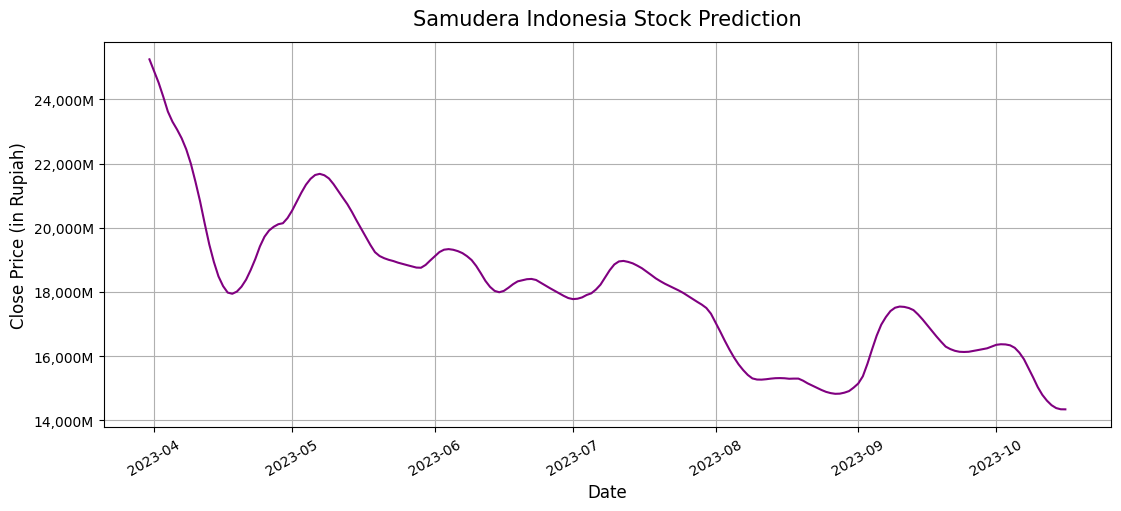

In [32]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [33]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 21s 579ms/step - loss: 0.0068 - val_loss: 0.0052
Epoch 2/10
24/24 [==============================] - 11s 474ms/step - loss: 9.8493e-04 - val_loss: 0.0023
Epoch 3/10
24/24 [==============================] - 11s 466ms/step - loss: 7.4214e-04 - val_loss: 0.0024
Epoch 4/10
24/24 [==============================] - 12s 490ms/step - loss: 5.8859e-04 - val_loss: 0.0038
Epoch 5/10
24/24 [==============================] - 12s 485ms/step - loss: 5.3628e-04 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 12s 501ms/step - loss: 5.1219e-04 - val_loss: 0.0028
Epoch 7/10
24/24 [==============================] - 12s 496ms/step - loss: 4.5900e-04 - val_loss: 0.0028
Epoch 8/10
24/24 [==============================] - 12s 491ms/step - loss: 4.3125e-04 - val_loss: 0.0024
Epoch 9/10
24/24 [==============================] - 12s 485ms/step - loss: 4.4874e-04 - val_loss: 0.0022
Epoch 10/10
24/24 [==============================] - 12s 51

In [34]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 0.3489477
Mean Absolute Percentage Error (MAPE): 0.15544
Root Mean Squared Error (RMSE): 0.39817
Mean Squared Error (MSE): 0.1585388
R-Squared (R2): 0.119377
T-Statistic 0.9138
P-Value 1.6801630919882626e-10
Elapsed Time (min): 127.87


7/7 [==============================] - 0s 38ms/step


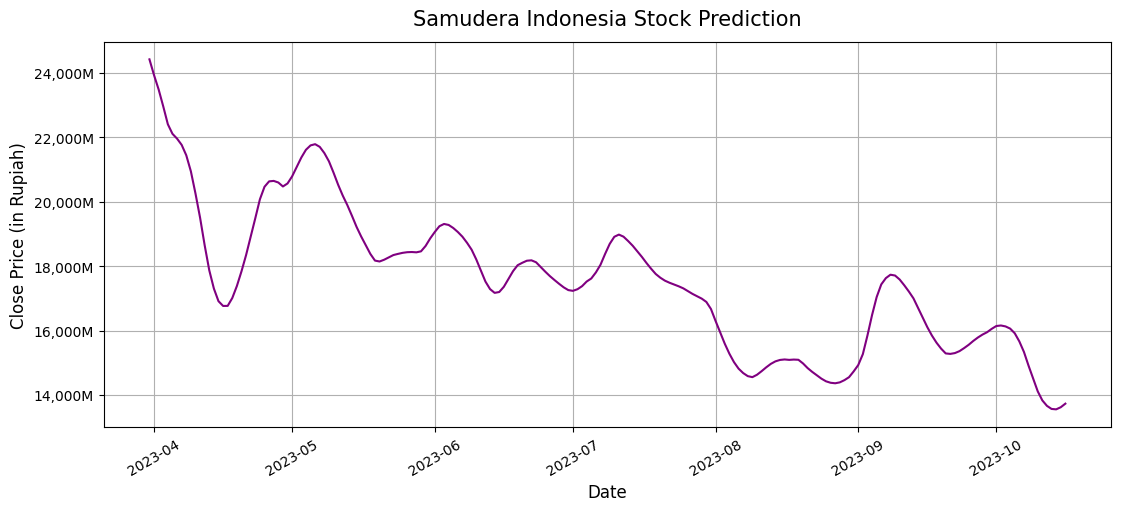

In [35]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [36]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 21s 595ms/step - loss: 0.0311 - val_loss: 0.2335
Epoch 2/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0243 - val_loss: 0.2143
Epoch 3/10
24/24 [==============================] - 11s 457ms/step - loss: 0.0194 - val_loss: 0.1959
Epoch 4/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0162 - val_loss: 0.1820
Epoch 5/10
24/24 [==============================] - 11s 442ms/step - loss: 0.0140 - val_loss: 0.1713
Epoch 6/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0128 - val_loss: 0.1630
Epoch 7/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0118 - val_loss: 0.1562
Epoch 8/10
24/24 [==============================] - 11s 460ms/step - loss: 0.0113 - val_loss: 0.1509
Epoch 9/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0108 - val_loss: 0.1465
Epoch 10/10
24/24 [==============================] - 11s 447ms/step - loss: 0.0104 - val_lo

In [37]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 2.0320714
Mean Absolute Percentage Error (MAPE): 0.93917
Root Mean Squared Error (RMSE): 2.07788
Mean Squared Error (MSE): 4.3175704
R-Squared (R2): -22.982463
T-Statistic 0.8611
P-Value 7.43195381538303e-14
Elapsed Time (min): 119.61


7/7 [==============================] - 0s 38ms/step


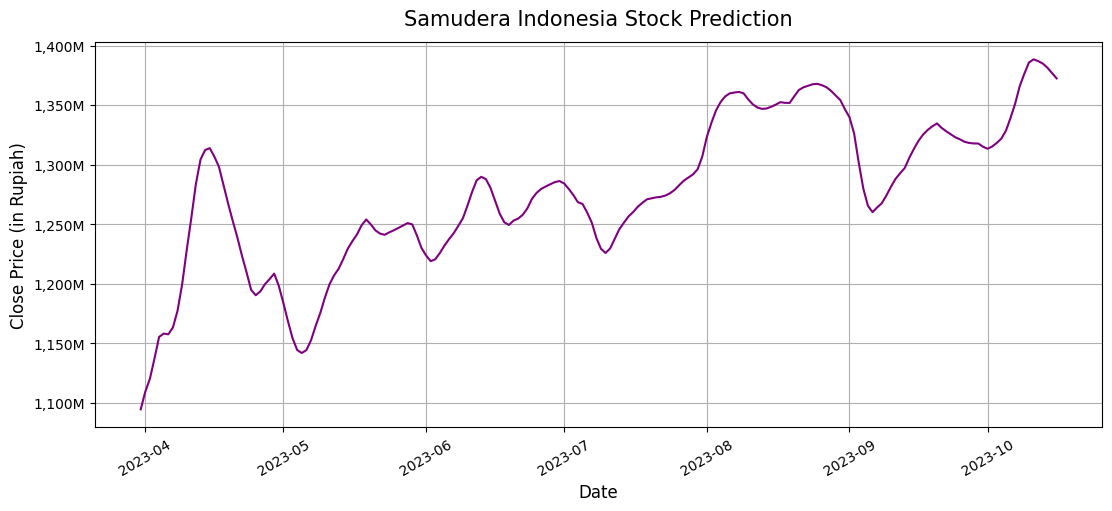

In [38]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [39]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 23s 564ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 2/10
24/24 [==============================] - 9s 387ms/step - loss: 7.8712e-04 - val_loss: 0.0029
Epoch 3/10
24/24 [==============================] - 10s 404ms/step - loss: 6.6341e-04 - val_loss: 0.0026
Epoch 4/10
24/24 [==============================] - 9s 393ms/step - loss: 5.9104e-04 - val_loss: 0.0045
Epoch 5/10
24/24 [==============================] - 9s 387ms/step - loss: 5.1028e-04 - val_loss: 0.0032
Epoch 6/10
24/24 [==============================] - 9s 396ms/step - loss: 5.0485e-04 - val_loss: 0.0028
Epoch 7/10
24/24 [==============================] - 10s 397ms/step - loss: 4.2778e-04 - val_loss: 0.0034
Epoch 8/10
24/24 [==============================] - 10s 419ms/step - loss: 4.4458e-04 - val_loss: 0.0035
Epoch 9/10
24/24 [==============================] - 10s 405ms/step - loss: 3.7602e-04 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 10s 408ms/

In [40]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Error (MAE): 0.4412922
Mean Absolute Percentage Error (MAPE): 0.19799
Root Mean Squared Error (RMSE): 0.48847
Mean Squared Error (MSE): 0.2385993
R-Squared (R2): -0.325328
T-Statistic 0.9019
P-Value 2.3226809364729206e-11
Elapsed Time (min): 110.22


7/7 [==============================] - 0s 36ms/step


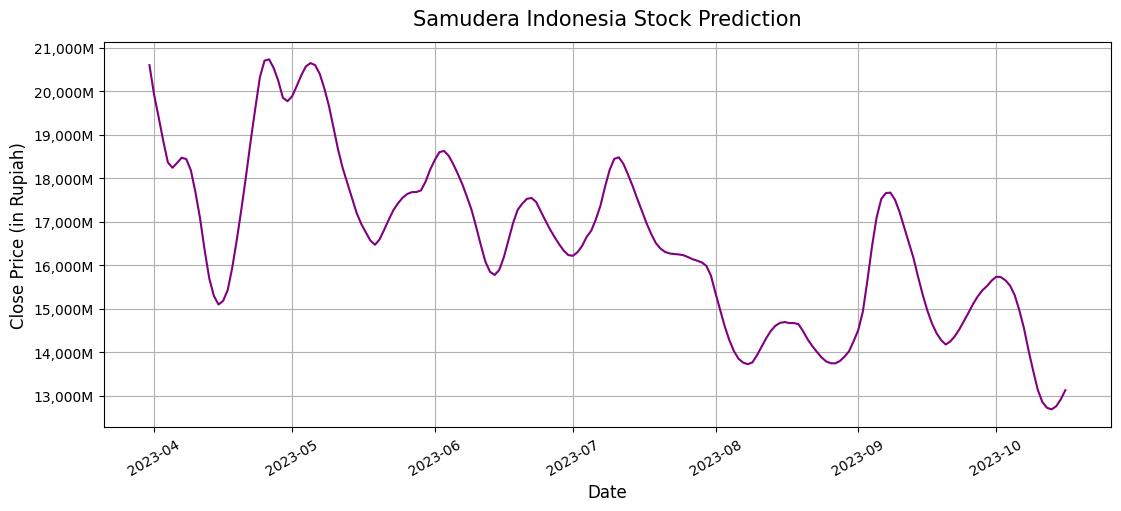

In [41]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [42]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 16s 401ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 2/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 3/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 4/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 5/10
24/24 [==============================] - 7s 297ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 6/10
24/24 [==============================] - 7s 274ms/step - loss: 7.8220e-04 - val_loss: 0.0033
Epoch 7/10
24/24 [==============================] - 7s 286ms/step - loss: 8.2695e-04 - val_loss: 0.0023
Epoch 8/10
24/24 [==============================] - 6s 240ms/step - loss: 7.1798e-04 - val_loss: 0.0111
Epoch 9/10
24/24 [==============================] - 5s 222ms/step - loss: 7.8613e-04 - val_loss: 0.0023
Epoch 10/10
24/24 [==============================] - 5s 227ms/step - loss: 6.1300e-

In [43]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.4054026
Mean Absolute Percentage Error (MAPE): 0.17519
Root Mean Squared Error (RMSE): 0.48591
Mean Squared Error (MSE): 0.2361109
R-Squared (R2): -0.311507
T-Statistic 0.9635
P-Value 9.030618457472883e-06
Elapsed Time (min): 72.56


7/7 [==============================] - 0s 37ms/step


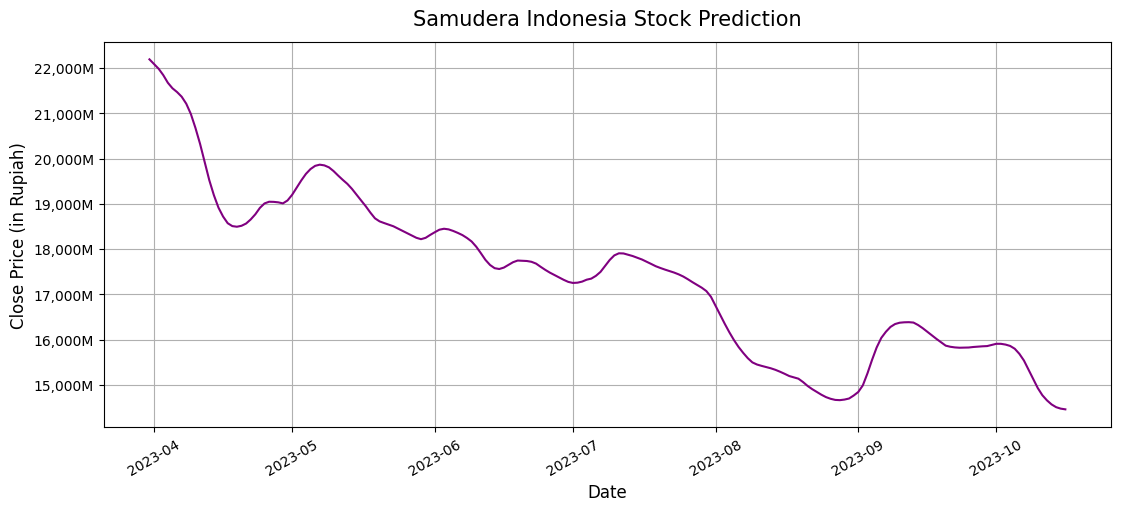

In [44]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [45]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 28s 753ms/step - loss: 0.0275 - val_loss: 0.2059
Epoch 2/10
24/24 [==============================] - 16s 687ms/step - loss: 0.0271 - val_loss: 0.2040
Epoch 3/10
24/24 [==============================] - 16s 647ms/step - loss: 0.0267 - val_loss: 0.2021
Epoch 4/10
24/24 [==============================] - 16s 654ms/step - loss: 0.0261 - val_loss: 0.2001
Epoch 5/10
24/24 [==============================] - 15s 642ms/step - loss: 0.0258 - val_loss: 0.1982
Epoch 6/10
24/24 [==============================] - 16s 663ms/step - loss: 0.0254 - val_loss: 0.1962
Epoch 7/10
24/24 [==============================] - 16s 656ms/step - loss: 0.0249 - val_loss: 0.1941
Epoch 8/10
24/24 [==============================] - 15s 633ms/step - loss: 0.0245 - val_loss: 0.1920
Epoch 9/10
24/24 [==============================] - 16s 673ms/step - loss: 0.0242 - val_loss: 0.1898
Epoch 10/10
24/24 [==============================] - 17s 731ms/step - loss: 0.0237 - val_lo

In [46]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 62ms/step
Mean Absolute Error (MAE): 1.9350504
Mean Absolute Percentage Error (MAPE): 0.89484
Root Mean Squared Error (RMSE): 1.97778
Mean Squared Error (MSE): 3.9116207
R-Squared (R2): -20.727567
T-Statistic 0.9808
P-Value 0.0025782121811062098
Elapsed Time (min): 173.14


7/7 [==============================] - 0s 59ms/step


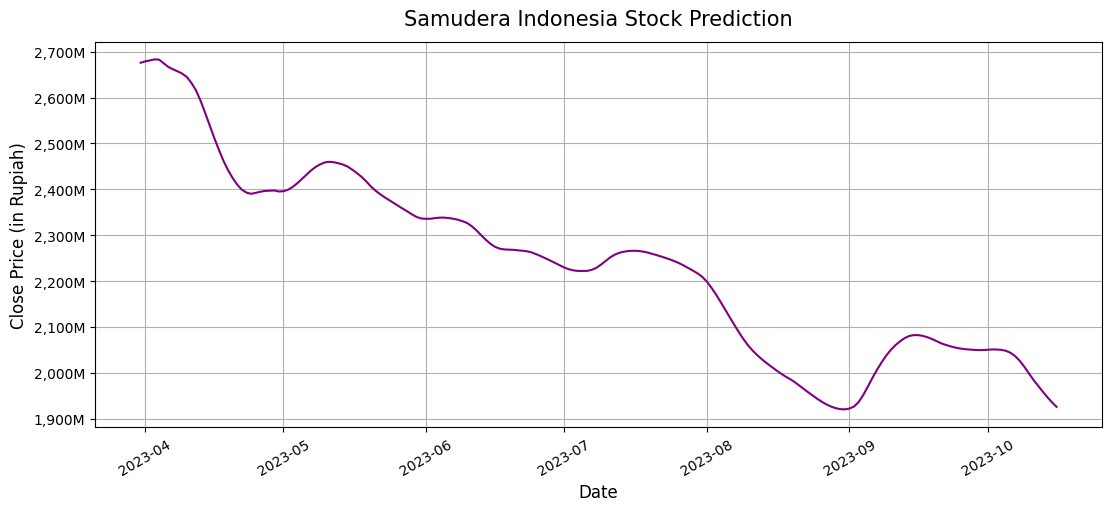

In [47]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [48]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 27s 818ms/step - loss: 0.0180 - val_loss: 0.1504
Epoch 2/10
24/24 [==============================] - 19s 790ms/step - loss: 0.0101 - val_loss: 0.1311
Epoch 3/10
24/24 [==============================] - 20s 811ms/step - loss: 0.0093 - val_loss: 0.1224
Epoch 4/10
24/24 [==============================] - 19s 785ms/step - loss: 0.0086 - val_loss: 0.1140
Epoch 5/10
24/24 [==============================] - 18s 764ms/step - loss: 0.0080 - val_loss: 0.1093
Epoch 6/10
24/24 [==============================] - 18s 756ms/step - loss: 0.0075 - val_loss: 0.1052
Epoch 7/10
24/24 [==============================] - 19s 792ms/step - loss: 0.0072 - val_loss: 0.1013
Epoch 8/10
24/24 [==============================] - 17s 698ms/step - loss: 0.0070 - val_loss: 0.0965
Epoch 9/10
24/24 [==============================] - 17s 721ms/step - loss: 0.0067 - val_loss: 0.0938
Epoch 10/10
24/24 [==============================] - 17s 729ms/step - loss: 0.0066 - val_lo

In [49]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 65ms/step
Mean Absolute Error (MAE): 1.783136
Mean Absolute Percentage Error (MAPE): 0.82222
Root Mean Squared Error (RMSE): 1.82839
Mean Squared Error (MSE): 3.3430151
R-Squared (R2): -17.569179
T-Statistic 0.961
P-Value 4.510836333793122e-06
Elapsed Time (min): 193.23


7/7 [==============================] - 0s 61ms/step


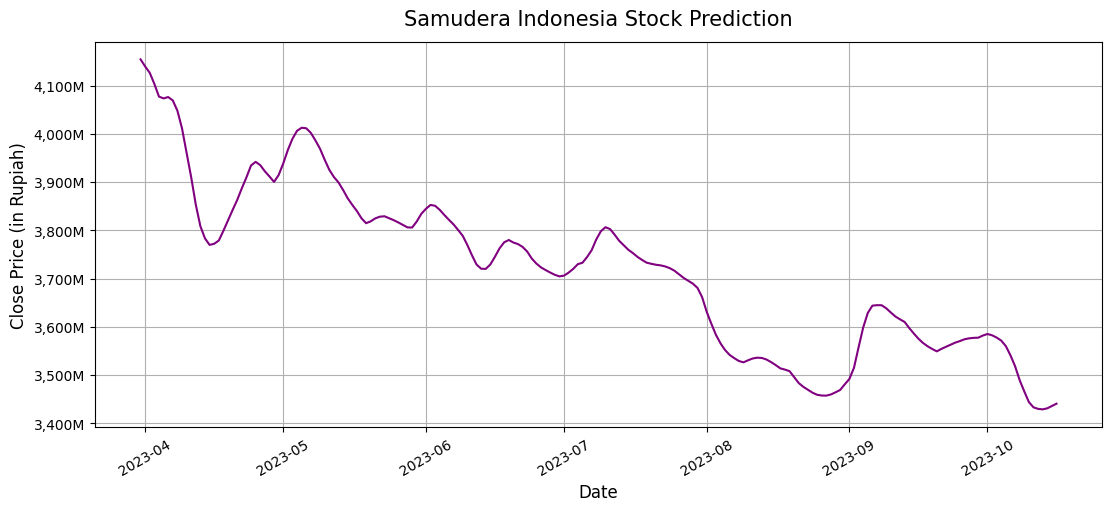

In [50]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [51]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 24s 715ms/step - loss: 0.0086 - val_loss: 0.0202
Epoch 2/10
24/24 [==============================] - 16s 688ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 3/10
24/24 [==============================] - 17s 701ms/step - loss: 9.8294e-04 - val_loss: 0.0035
Epoch 4/10
24/24 [==============================] - 17s 700ms/step - loss: 9.4841e-04 - val_loss: 0.0036
Epoch 5/10
24/24 [==============================] - 16s 668ms/step - loss: 9.4450e-04 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 17s 707ms/step - loss: 8.3491e-04 - val_loss: 0.0040
Epoch 7/10
24/24 [==============================] - 17s 710ms/step - loss: 7.6060e-04 - val_loss: 0.0039
Epoch 8/10
24/24 [==============================] - 17s 705ms/step - loss: 7.3977e-04 - val_loss: 0.0036
Epoch 9/10
24/24 [==============================] - 17s 724ms/step - loss: 7.1223e-04 - val_loss: 0.0037
Epoch 10/10
24/24 [==============================] - 18s 732ms/

In [52]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 68ms/step
Mean Absolute Error (MAE): 0.5362993
Mean Absolute Percentage Error (MAPE): 0.23549
Root Mean Squared Error (RMSE): 0.60631
Mean Squared Error (MSE): 0.3676068
R-Squared (R2): -1.041916
T-Statistic 0.9514
P-Value 3.648249560228578e-07
Elapsed Time (min): 177.01


7/7 [==============================] - 0s 63ms/step


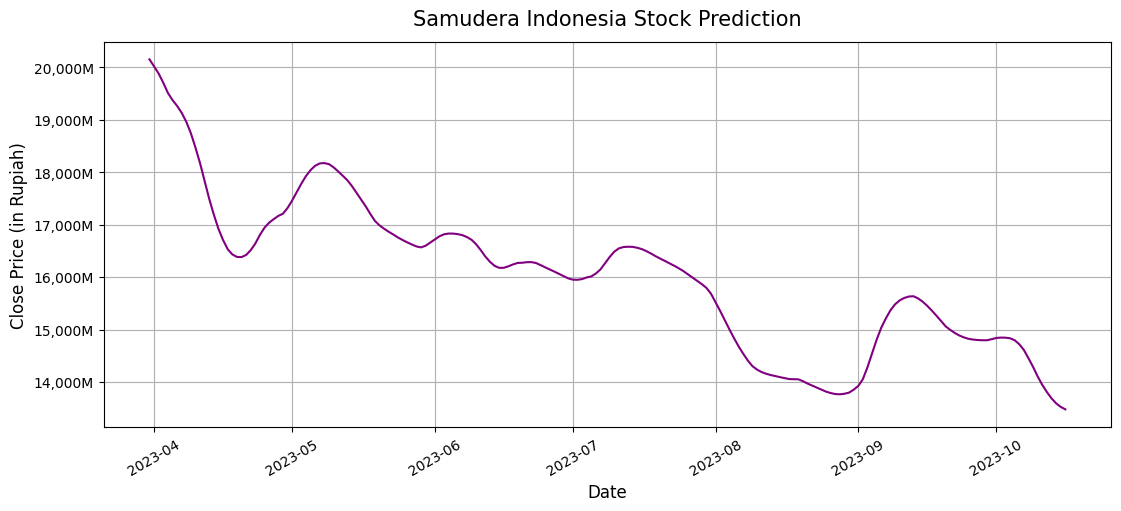

In [53]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [54]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 26s 705ms/step - loss: 0.0517 - val_loss: 0.1670
Epoch 2/10
24/24 [==============================] - 16s 680ms/step - loss: 0.0119 - val_loss: 0.1156
Epoch 3/10
24/24 [==============================] - 17s 732ms/step - loss: 0.0041 - val_loss: 0.0365
Epoch 4/10
24/24 [==============================] - 18s 743ms/step - loss: 0.0016 - val_loss: 0.0205
Epoch 5/10
24/24 [==============================] - 16s 673ms/step - loss: 0.0012 - val_loss: 0.0134
Epoch 6/10
24/24 [==============================] - 15s 647ms/step - loss: 0.0010 - val_loss: 0.0131
Epoch 7/10
24/24 [==============================] - 16s 659ms/step - loss: 8.9698e-04 - val_loss: 0.0107
Epoch 8/10
24/24 [==============================] - 17s 701ms/step - loss: 7.9025e-04 - val_loss: 0.0090
Epoch 9/10
24/24 [==============================] - 16s 677ms/step - loss: 7.0076e-04 - val_loss: 0.0078
Epoch 10/10
24/24 [==============================] - 17s 699ms/step - loss: 6.4

In [55]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 66ms/step
Mean Absolute Error (MAE): 1.1191406
Mean Absolute Percentage Error (MAPE): 0.50405
Root Mean Squared Error (RMSE): 1.18894
Mean Squared Error (MSE): 1.4135866
R-Squared (R2): -6.851936
T-Statistic 0.9718
P-Value 0.0001139521918958053
Elapsed Time (min): 176.3


7/7 [==============================] - 1s 75ms/step


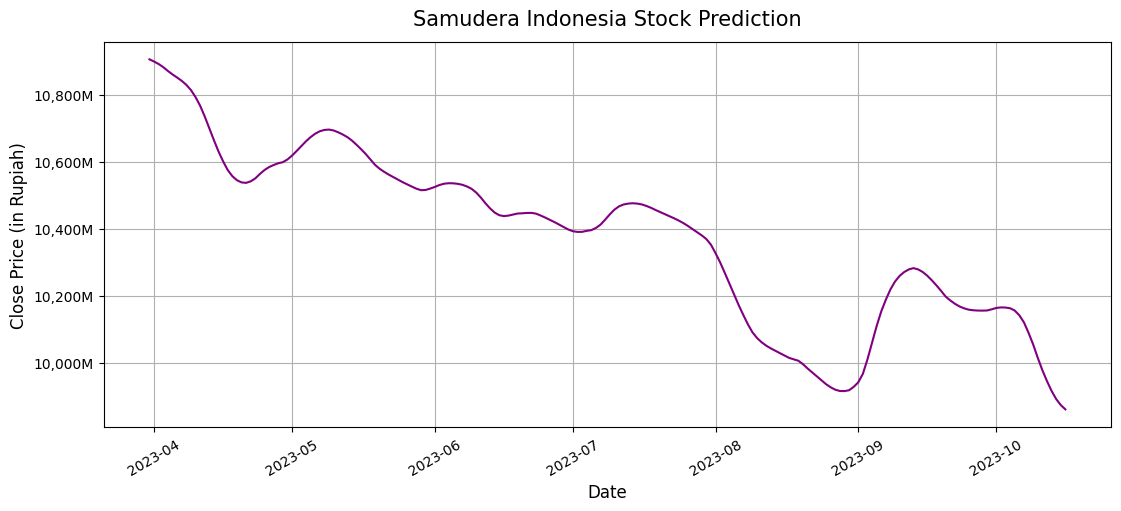

In [56]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [57]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 22s 649ms/step - loss: 0.1514 - val_loss: 0.4213
Epoch 2/10
24/24 [==============================] - 13s 540ms/step - loss: 0.0856 - val_loss: 0.3396
Epoch 3/10
24/24 [==============================] - 13s 536ms/step - loss: 0.0565 - val_loss: 0.2892
Epoch 4/10
24/24 [==============================] - 13s 529ms/step - loss: 0.0400 - val_loss: 0.2544
Epoch 5/10
24/24 [==============================] - 13s 542ms/step - loss: 0.0298 - val_loss: 0.2291
Epoch 6/10
24/24 [==============================] - 13s 541ms/step - loss: 0.0233 - val_loss: 0.2102
Epoch 7/10
24/24 [==============================] - 13s 529ms/step - loss: 0.0192 - val_loss: 0.1957
Epoch 8/10
24/24 [==============================] - 12s 518ms/step - loss: 0.0162 - val_loss: 0.1844
Epoch 9/10
24/24 [==============================] - 12s 508ms/step - loss: 0.0144 - val_loss: 0.1755
Epoch 10/10
24/24 [==============================] - 13s 557ms/step - loss: 0.0131 - val_lo

In [58]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 48ms/step
Mean Absolute Error (MAE): 2.061405
Mean Absolute Percentage Error (MAPE): 0.95381
Root Mean Squared Error (RMSE): 2.10508
Mean Squared Error (MSE): 4.4313475
R-Squared (R2): -23.614451
T-Statistic 0.9614
P-Value 4.985433406545781e-06
Elapsed Time (min): 138.71


7/7 [==============================] - 0s 49ms/step


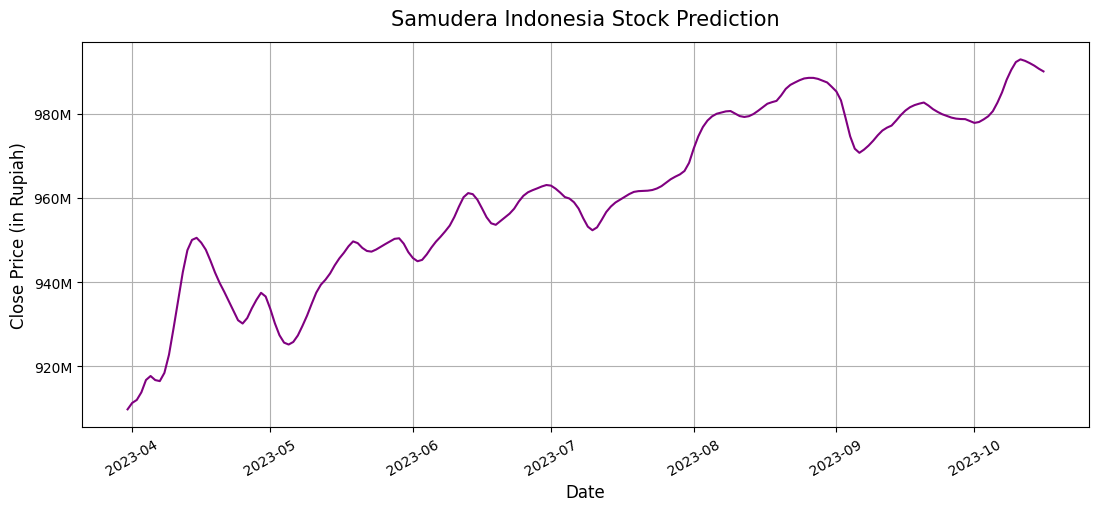

In [59]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [60]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 26s 711ms/step - loss: 0.1073 - val_loss: 0.0226
Epoch 2/10
24/24 [==============================] - 15s 631ms/step - loss: 0.0035 - val_loss: 0.0227
Epoch 3/10
24/24 [==============================] - 15s 631ms/step - loss: 0.0027 - val_loss: 0.0173
Epoch 4/10
24/24 [==============================] - 14s 598ms/step - loss: 0.0024 - val_loss: 0.0136
Epoch 5/10
24/24 [==============================] - 16s 654ms/step - loss: 0.0020 - val_loss: 0.0115
Epoch 6/10
24/24 [==============================] - 16s 658ms/step - loss: 0.0021 - val_loss: 0.0113
Epoch 7/10
24/24 [==============================] - 15s 643ms/step - loss: 0.0017 - val_loss: 0.0081
Epoch 8/10
24/24 [==============================] - 18s 745ms/step - loss: 0.0016 - val_loss: 0.0085
Epoch 9/10
24/24 [==============================] - 18s 775ms/step - loss: 0.0016 - val_loss: 0.0101
Epoch 10/10
24/24 [==============================] - 19s 801ms/step - loss: 0.0014 - val_lo

In [61]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 56ms/step
Mean Absolute Error (MAE): 0.8827884
Mean Absolute Percentage Error (MAPE): 0.39446
Root Mean Squared Error (RMSE): 0.95544
Mean Squared Error (MSE): 0.9128652
R-Squared (R2): -4.07062
T-Statistic 0.9579
P-Value 1.9348524347151397e-06
Elapsed Time (min): 174.26


7/7 [==============================] - 0s 56ms/step


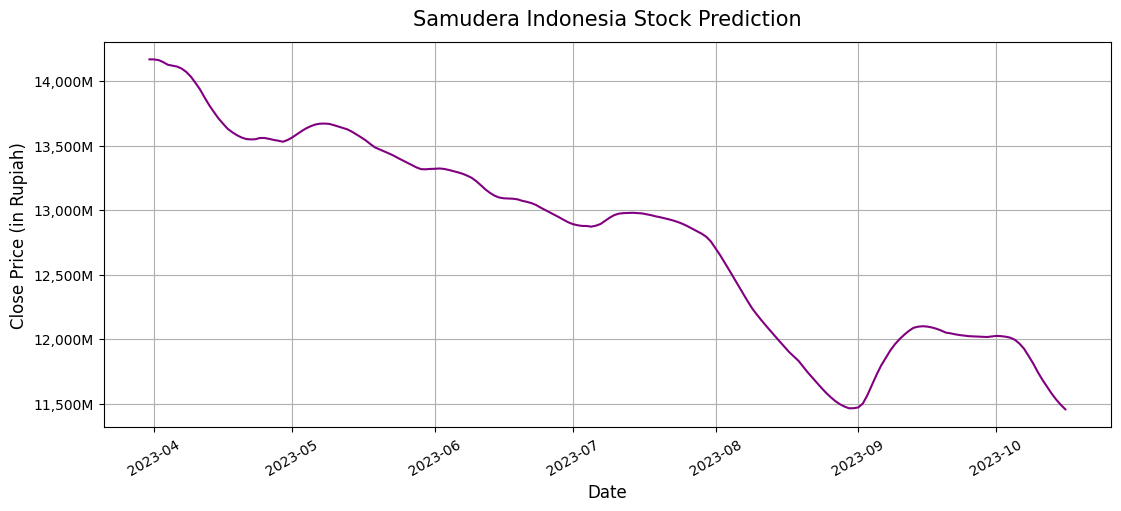

In [62]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [63]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 24s 706ms/step - loss: 0.0063 - val_loss: 0.0245
Epoch 2/10
24/24 [==============================] - 16s 659ms/step - loss: 0.0014 - val_loss: 0.0110
Epoch 3/10
24/24 [==============================] - 17s 693ms/step - loss: 0.0017 - val_loss: 0.0168
Epoch 4/10
24/24 [==============================] - 16s 658ms/step - loss: 0.0014 - val_loss: 0.0092
Epoch 5/10
24/24 [==============================] - 17s 722ms/step - loss: 0.0011 - val_loss: 0.0116
Epoch 6/10
24/24 [==============================] - 17s 705ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 7/10
24/24 [==============================] - 16s 661ms/step - loss: 0.0011 - val_loss: 0.0068
Epoch 8/10
24/24 [==============================] - 17s 712ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 9/10
24/24 [==============================] - 18s 748ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 10/10
24/24 [==============================] - 18s 731ms/step - loss: 9.3575e-04 - va

In [64]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 54ms/step
Mean Absolute Error (MAE): 1.0499303
Mean Absolute Percentage Error (MAPE): 0.47232
Root Mean Squared Error (RMSE): 1.11865
Mean Squared Error (MSE): 1.2513875
R-Squared (R2): -5.950982
T-Statistic 0.9786
P-Value 0.001162951230071485
Elapsed Time (min): 175.78


7/7 [==============================] - 0s 50ms/step


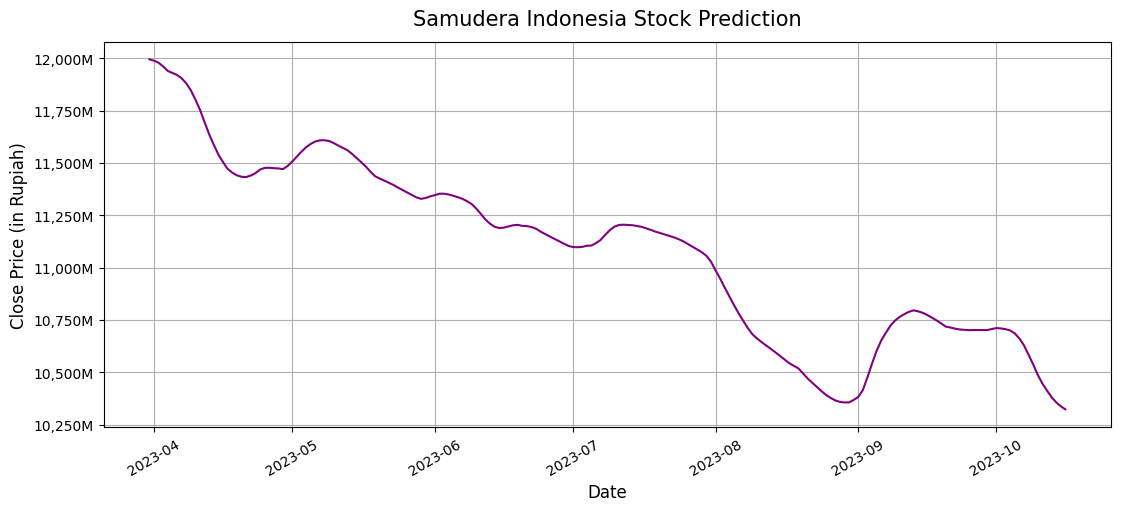

In [65]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [66]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 27s 808ms/step - loss: 2.1692 - val_loss: 1.4374
Epoch 2/10
24/24 [==============================] - 17s 724ms/step - loss: 2.1657 - val_loss: 1.4336
Epoch 3/10
24/24 [==============================] - 17s 697ms/step - loss: 2.1620 - val_loss: 1.4298
Epoch 4/10
24/24 [==============================] - 17s 699ms/step - loss: 2.1583 - val_loss: 1.4259
Epoch 5/10
24/24 [==============================] - 17s 694ms/step - loss: 2.1547 - val_loss: 1.4219
Epoch 6/10
24/24 [==============================] - 16s 682ms/step - loss: 2.1505 - val_loss: 1.4179
Epoch 7/10
24/24 [==============================] - 17s 696ms/step - loss: 2.1466 - val_loss: 1.4137
Epoch 8/10
24/24 [==============================] - 17s 692ms/step - loss: 2.1426 - val_loss: 1.4095
Epoch 9/10
24/24 [==============================] - 17s 706ms/step - loss: 2.1385 - val_loss: 1.4052
Epoch 10/10
24/24 [==============================] - 17s 704ms/step - loss: 2.1341 - val_lo

In [67]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 66ms/step
Mean Absolute Error (MAE): 0.6316804
Mean Absolute Percentage Error (MAPE): 0.2673
Root Mean Squared Error (RMSE): 0.76609
Mean Squared Error (MSE): 0.5868883
R-Squared (R2): -2.259942
T-Statistic 0.9683
P-Value 3.815198579104617e-05
Elapsed Time (min): 178.63


7/7 [==============================] - 0s 57ms/step


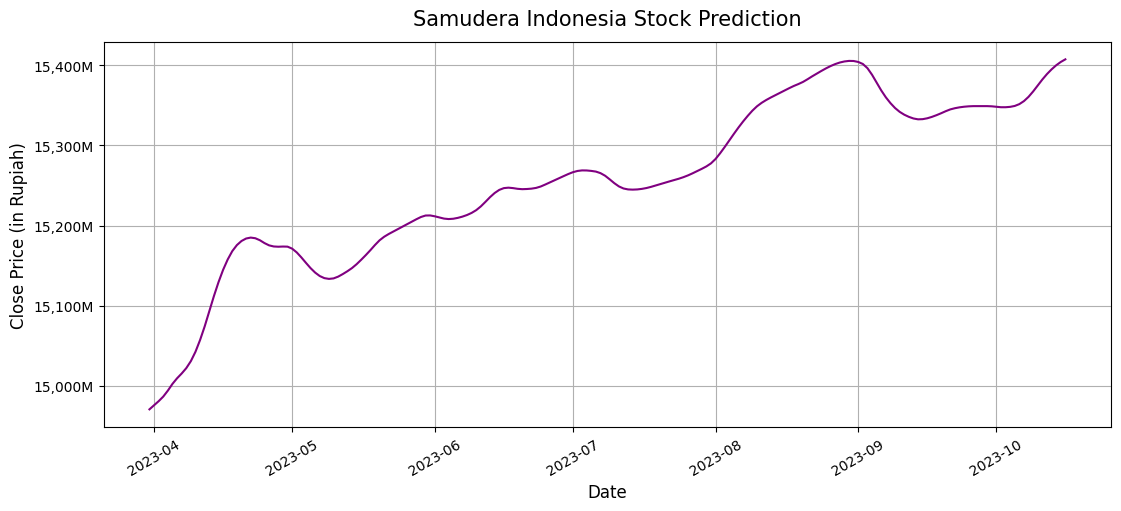

In [68]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [69]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 25s 753ms/step - loss: 0.0346 - val_loss: 0.1388
Epoch 2/10
24/24 [==============================] - 16s 673ms/step - loss: 0.0101 - val_loss: 0.1340
Epoch 3/10
24/24 [==============================] - 17s 697ms/step - loss: 0.0100 - val_loss: 0.1337
Epoch 4/10
24/24 [==============================] - 17s 706ms/step - loss: 0.0100 - val_loss: 0.1330
Epoch 5/10
24/24 [==============================] - 17s 712ms/step - loss: 0.0099 - val_loss: 0.1321
Epoch 6/10
24/24 [==============================] - 17s 696ms/step - loss: 0.0099 - val_loss: 0.1347
Epoch 7/10
24/24 [==============================] - 16s 686ms/step - loss: 0.0099 - val_loss: 0.1308
Epoch 8/10
24/24 [==============================] - 18s 736ms/step - loss: 0.0098 - val_loss: 0.1327
Epoch 9/10
24/24 [==============================] - 17s 711ms/step - loss: 0.0098 - val_loss: 0.1321
Epoch 10/10
24/24 [==============================] - 18s 744ms/step - loss: 0.0098 - val_lo

In [70]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Error (MAE): 1.9433511
Mean Absolute Percentage Error (MAPE): 0.89779
Root Mean Squared Error (RMSE): 1.98819
Mean Squared Error (MSE): 3.9528967
R-Squared (R2): -20.956839
T-Statistic 0.9782
P-Value 0.000985562801361084
Elapsed Time (min): 178.08


7/7 [==============================] - 0s 52ms/step


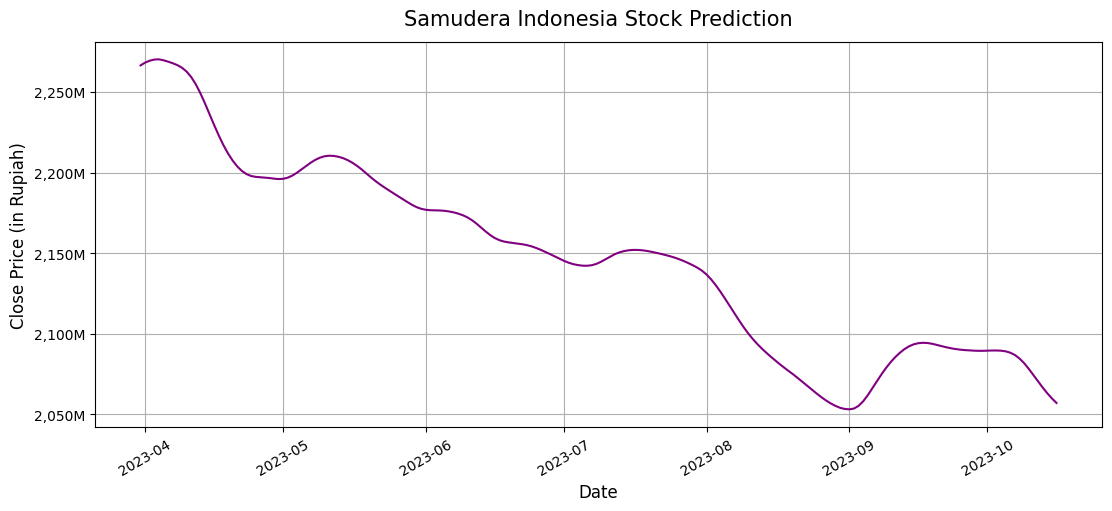

In [71]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [72]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 24s 742ms/step - loss: 0.2679 - val_loss: 0.0605
Epoch 2/10
24/24 [==============================] - 17s 713ms/step - loss: 0.0095 - val_loss: 0.0363
Epoch 3/10
24/24 [==============================] - 17s 721ms/step - loss: 0.0048 - val_loss: 0.0345
Epoch 4/10
24/24 [==============================] - 17s 695ms/step - loss: 0.0043 - val_loss: 0.0344
Epoch 5/10
24/24 [==============================] - 17s 700ms/step - loss: 0.0040 - val_loss: 0.0318
Epoch 6/10
24/24 [==============================] - 16s 675ms/step - loss: 0.0041 - val_loss: 0.0281
Epoch 7/10
24/24 [==============================] - 16s 673ms/step - loss: 0.0038 - val_loss: 0.0283
Epoch 8/10
24/24 [==============================] - 16s 678ms/step - loss: 0.0038 - val_loss: 0.0269
Epoch 9/10
24/24 [==============================] - 17s 699ms/step - loss: 0.0038 - val_loss: 0.0248
Epoch 10/10
24/24 [==============================] - 17s 691ms/step - loss: 0.0035 - val_lo

In [73]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 59ms/step
Mean Absolute Error (MAE): 1.4587871
Mean Absolute Percentage Error (MAPE): 0.6665
Root Mean Squared Error (RMSE): 1.51436
Mean Squared Error (MSE): 2.2933001
R-Squared (R2): -11.73841
T-Statistic 0.9825
P-Value 0.004998856224119663
Elapsed Time (min): 175.23


7/7 [==============================] - 0s 56ms/step


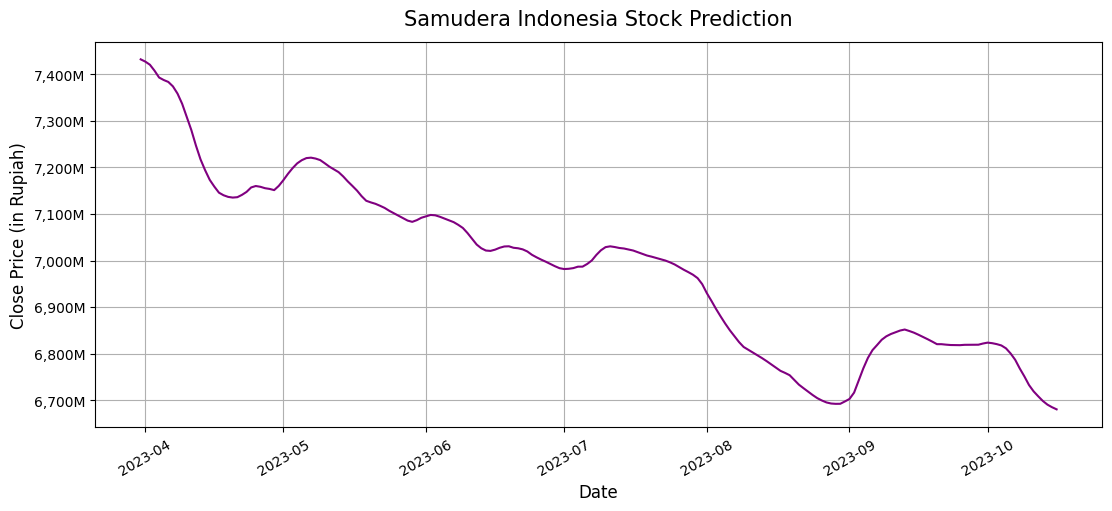

In [74]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [75]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 25s 747ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 2/10
24/24 [==============================] - 18s 746ms/step - loss: 8.0592e-04 - val_loss: 0.0036
Epoch 3/10
24/24 [==============================] - 17s 724ms/step - loss: 6.0859e-04 - val_loss: 0.0023
Epoch 4/10
24/24 [==============================] - 17s 699ms/step - loss: 5.2083e-04 - val_loss: 0.0020
Epoch 5/10
24/24 [==============================] - 16s 684ms/step - loss: 5.1417e-04 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 16s 686ms/step - loss: 4.7953e-04 - val_loss: 0.0022
Epoch 7/10
24/24 [==============================] - 17s 722ms/step - loss: 3.8575e-04 - val_loss: 0.0022
Epoch 8/10
24/24 [==============================] - 20s 844ms/step - loss: 4.1134e-04 - val_loss: 0.0021
Epoch 9/10
24/24 [==============================] - 18s 735ms/step - loss: 3.8522e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 18s 71

In [76]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 52ms/step
Mean Absolute Error (MAE): 0.3569744
Mean Absolute Percentage Error (MAPE): 0.15756
Root Mean Squared Error (RMSE): 0.41006
Mean Squared Error (MSE): 0.1681515
R-Squared (R2): 0.065982
T-Statistic 0.9265
P-Value 1.6911096967220374e-09
Elapsed Time (min): 183.67


7/7 [==============================] - 0s 51ms/step


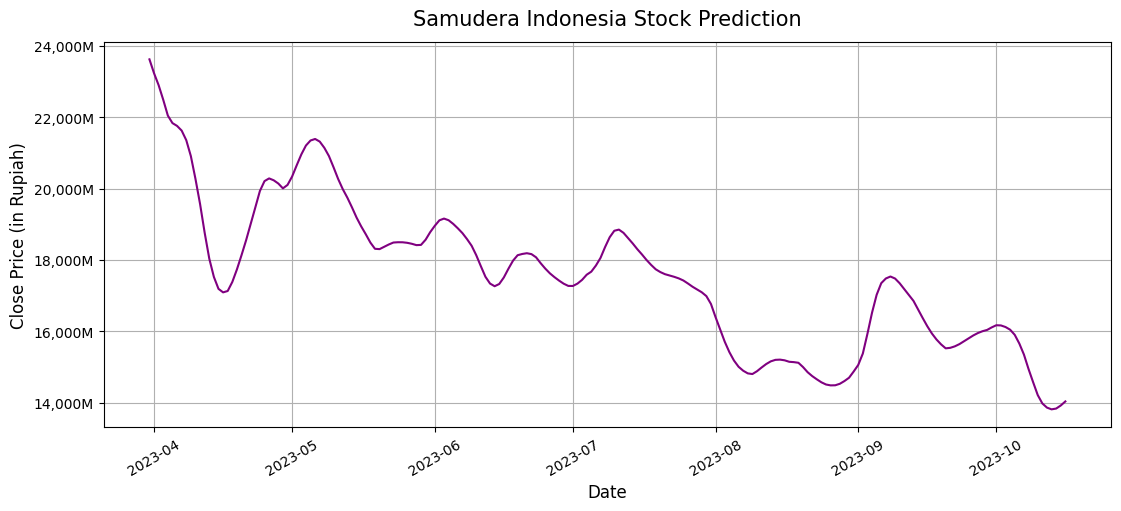

In [77]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [78]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 24s 765ms/step - loss: 0.0190 - val_loss: 0.1557
Epoch 2/10
24/24 [==============================] - 17s 712ms/step - loss: 0.0107 - val_loss: 0.1317
Epoch 3/10
24/24 [==============================] - 16s 667ms/step - loss: 0.0092 - val_loss: 0.1214
Epoch 4/10
24/24 [==============================] - 15s 632ms/step - loss: 0.0087 - val_loss: 0.1159
Epoch 5/10
24/24 [==============================] - 15s 641ms/step - loss: 0.0086 - val_loss: 0.1128
Epoch 6/10
24/24 [==============================] - 19s 787ms/step - loss: 0.0085 - val_loss: 0.1109
Epoch 7/10
24/24 [==============================] - 19s 776ms/step - loss: 0.0084 - val_loss: 0.1086
Epoch 8/10
24/24 [==============================] - 16s 650ms/step - loss: 0.0082 - val_loss: 0.1071
Epoch 9/10
24/24 [==============================] - 15s 642ms/step - loss: 0.0080 - val_loss: 0.1049
Epoch 10/10
24/24 [==============================] - 16s 661ms/step - loss: 0.0080 - val_lo

In [79]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 61ms/step
Mean Absolute Error (MAE): 1.7444241
Mean Absolute Percentage Error (MAPE): 0.80444
Root Mean Squared Error (RMSE): 1.78901
Mean Squared Error (MSE): 3.2005391
R-Squared (R2): -16.777778
T-Statistic 0.9715
P-Value 0.00010333654063288122
Elapsed Time (min): 173.93


7/7 [==============================] - 0s 59ms/step


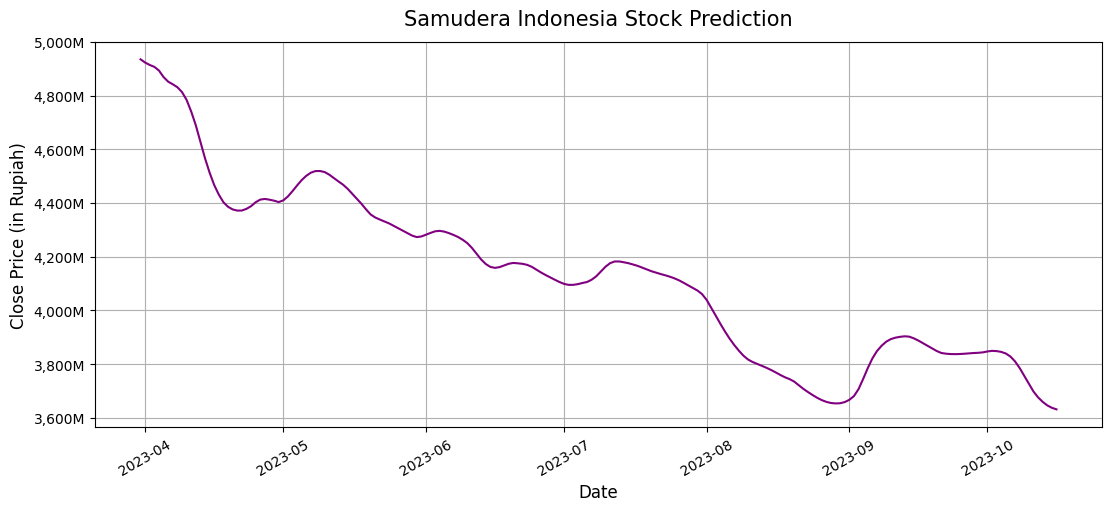

In [80]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [81]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 28s 784ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 2/10
24/24 [==============================] - 19s 806ms/step - loss: 7.2453e-04 - val_loss: 0.0026
Epoch 3/10
24/24 [==============================] - 18s 756ms/step - loss: 5.8952e-04 - val_loss: 0.0032
Epoch 4/10
24/24 [==============================] - 17s 708ms/step - loss: 5.3214e-04 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 16s 679ms/step - loss: 4.7493e-04 - val_loss: 0.0024
Epoch 6/10
24/24 [==============================] - 17s 697ms/step - loss: 4.6263e-04 - val_loss: 0.0025
Epoch 7/10
24/24 [==============================] - 18s 769ms/step - loss: 4.3300e-04 - val_loss: 0.0021
Epoch 8/10
24/24 [==============================] - 19s 785ms/step - loss: 4.0371e-04 - val_loss: 0.0050
Epoch 9/10
24/24 [==============================] - 18s 736ms/step - loss: 3.8723e-04 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 19s 78

In [82]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 59ms/step
Mean Absolute Error (MAE): 0.4370276
Mean Absolute Percentage Error (MAPE): 0.19432
Root Mean Squared Error (RMSE): 0.48801
Mean Squared Error (MSE): 0.2381563
R-Squared (R2): -0.322868
T-Statistic 0.9283
P-Value 2.398781173695852e-09
Elapsed Time (min): 190.53


7/7 [==============================] - 0s 59ms/step


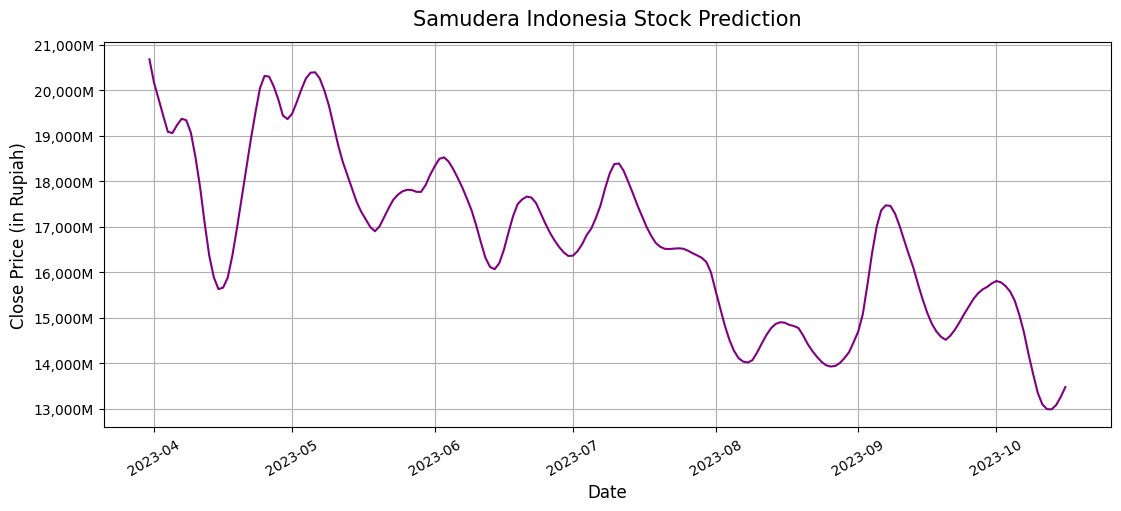

In [83]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [84]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 27s 780ms/step - loss: 0.0034 - val_loss: 0.0265
Epoch 2/10
24/24 [==============================] - 18s 749ms/step - loss: 0.0014 - val_loss: 0.0095
Epoch 3/10
24/24 [==============================] - 17s 723ms/step - loss: 0.0012 - val_loss: 0.0119
Epoch 4/10
24/24 [==============================] - 16s 683ms/step - loss: 0.0010 - val_loss: 0.0146
Epoch 5/10
24/24 [==============================] - 18s 732ms/step - loss: 0.0010 - val_loss: 0.0113
Epoch 6/10
24/24 [==============================] - 17s 685ms/step - loss: 9.2095e-04 - val_loss: 0.0025
Epoch 7/10
24/24 [==============================] - 16s 667ms/step - loss: 8.0926e-04 - val_loss: 0.0076
Epoch 8/10
24/24 [==============================] - 15s 641ms/step - loss: 8.3723e-04 - val_loss: 0.0031
Epoch 9/10
24/24 [==============================] - 15s 628ms/step - loss: 6.5008e-04 - val_loss: 0.0023
Epoch 10/10
24/24 [==============================] - 15s 631ms/step - loss:

In [85]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 61ms/step
Mean Absolute Error (MAE): 0.5245328
Mean Absolute Percentage Error (MAPE): 0.22956
Root Mean Squared Error (RMSE): 0.60034
Mean Squared Error (MSE): 0.360404
R-Squared (R2): -1.001907
T-Statistic 0.9708
P-Value 8.258142042905092e-05
Elapsed Time (min): 176.31


7/7 [==============================] - 0s 63ms/step


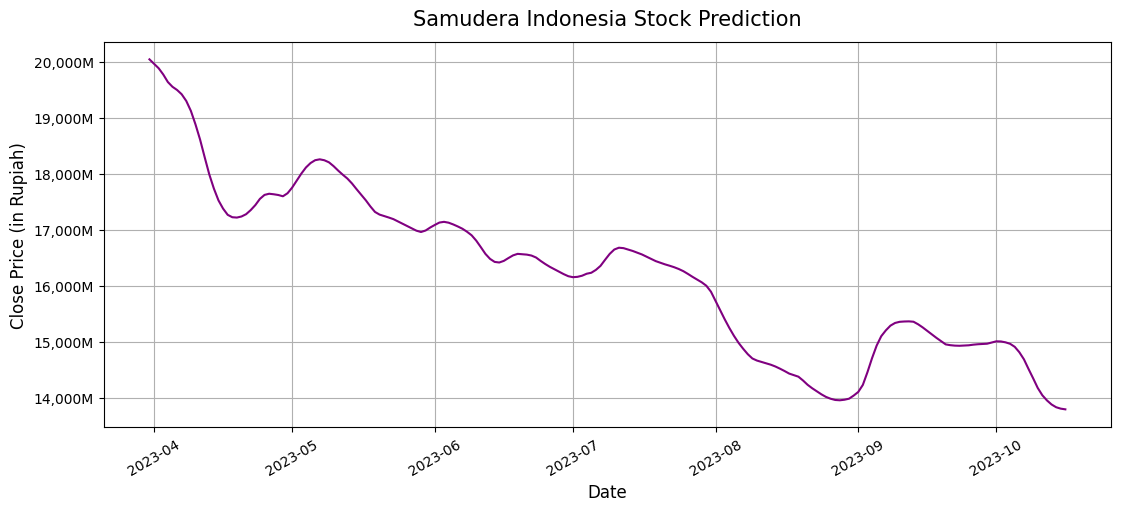

In [86]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [87]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 24s 702ms/step - loss: 0.0330 - val_loss: 0.2457
Epoch 2/10
24/24 [==============================] - 17s 690ms/step - loss: 0.0325 - val_loss: 0.2432
Epoch 3/10
24/24 [==============================] - 16s 672ms/step - loss: 0.0321 - val_loss: 0.2407
Epoch 4/10
24/24 [==============================] - 17s 694ms/step - loss: 0.0314 - val_loss: 0.2382
Epoch 5/10
24/24 [==============================] - 16s 678ms/step - loss: 0.0310 - val_loss: 0.2357
Epoch 6/10
24/24 [==============================] - 16s 664ms/step - loss: 0.0303 - val_loss: 0.2332
Epoch 7/10
24/24 [==============================] - 16s 657ms/step - loss: 0.0298 - val_loss: 0.2307
Epoch 8/10
24/24 [==============================] - 17s 698ms/step - loss: 0.0293 - val_loss: 0.2282
Epoch 9/10
24/24 [==============================] - 16s 689ms/step - loss: 0.0286 - val_loss: 0.2257
Epoch 10/10
24/24 [==============================] - 16s 686ms/step - loss: 0.0283 - val_lo

In [88]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 59ms/step
Mean Absolute Error (MAE): 2.093085
Mean Absolute Percentage Error (MAPE): 0.96907
Root Mean Squared Error (RMSE): 2.1361
Mean Squared Error (MSE): 4.5629419
R-Squared (R2): -24.345408
T-Statistic 0.7533
P-Value 1.3763437532754514e-18
Elapsed Time (min): 172.61


7/7 [==============================] - 0s 57ms/step


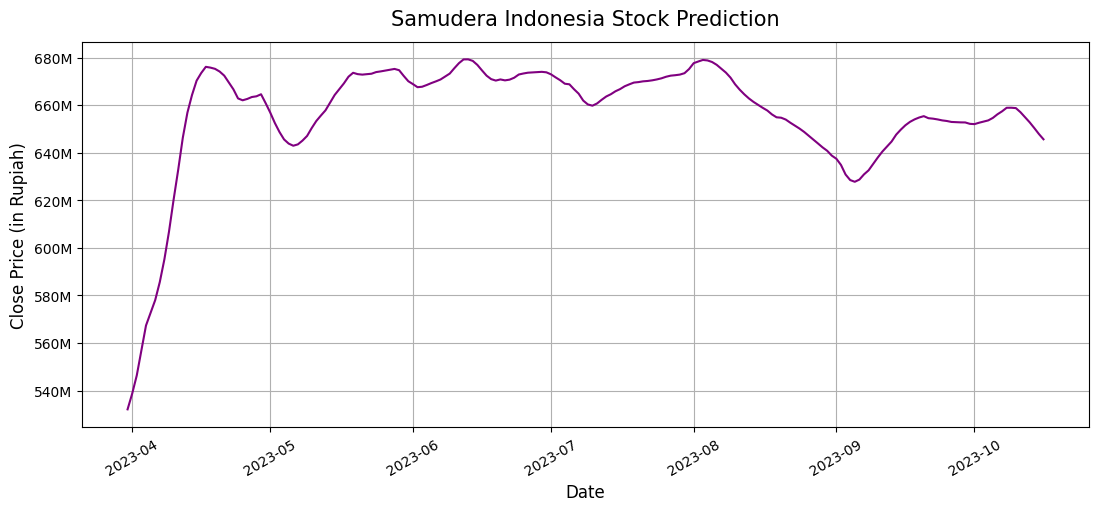

In [89]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [90]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 25s 738ms/step - loss: 0.0120 - val_loss: 0.1216
Epoch 2/10
24/24 [==============================] - 16s 664ms/step - loss: 0.0088 - val_loss: 0.1083
Epoch 3/10
24/24 [==============================] - 16s 679ms/step - loss: 0.0082 - val_loss: 0.1044
Epoch 4/10
24/24 [==============================] - 16s 665ms/step - loss: 0.0079 - val_loss: 0.0994
Epoch 5/10
24/24 [==============================] - 16s 684ms/step - loss: 0.0072 - val_loss: 0.0893
Epoch 6/10
24/24 [==============================] - 17s 692ms/step - loss: 0.0067 - val_loss: 0.0863
Epoch 7/10
24/24 [==============================] - 16s 660ms/step - loss: 0.0064 - val_loss: 0.0807
Epoch 8/10
24/24 [==============================] - 16s 658ms/step - loss: 0.0061 - val_loss: 0.0748
Epoch 9/10
24/24 [==============================] - 17s 719ms/step - loss: 0.0055 - val_loss: 0.0717
Epoch 10/10
24/24 [==============================] - 16s 685ms/step - loss: 0.0053 - val_lo

In [91]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 68ms/step
Mean Absolute Error (MAE): 1.4444561
Mean Absolute Percentage Error (MAPE): 0.66291
Root Mean Squared Error (RMSE): 1.49149
Mean Squared Error (MSE): 2.2245312
R-Squared (R2): -11.356426
T-Statistic 0.9772
P-Value 0.0007058879709802568
Elapsed Time (min): 172.5


7/7 [==============================] - 0s 59ms/step


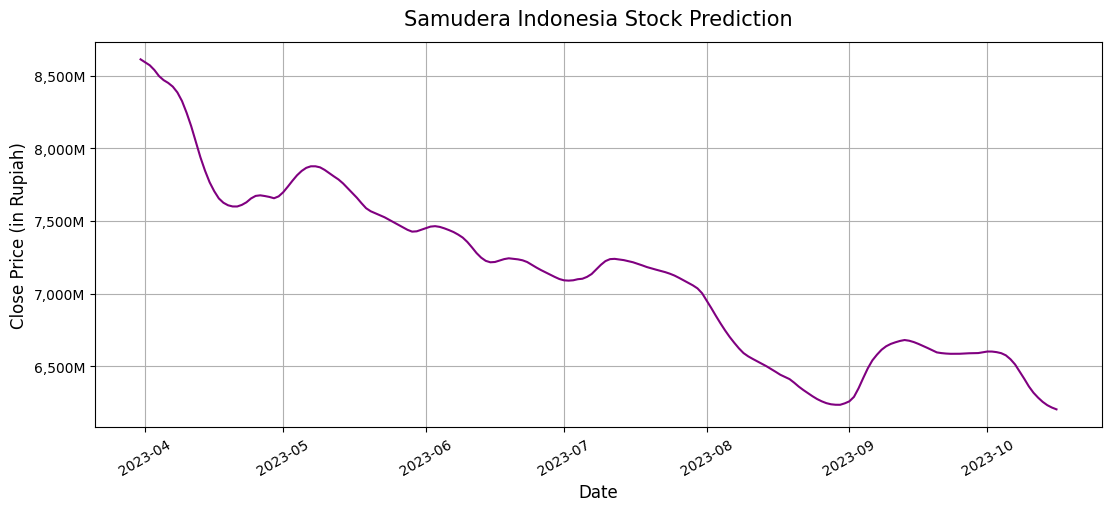

In [92]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [93]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/smdr_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 25s 715ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 2/10
24/24 [==============================] - 15s 645ms/step - loss: 8.7772e-04 - val_loss: 0.0028
Epoch 3/10
24/24 [==============================] - 16s 661ms/step - loss: 7.5115e-04 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 16s 690ms/step - loss: 7.4278e-04 - val_loss: 0.0033
Epoch 5/10
24/24 [==============================] - 16s 669ms/step - loss: 6.9862e-04 - val_loss: 0.0027
Epoch 6/10
24/24 [==============================] - 16s 678ms/step - loss: 6.9876e-04 - val_loss: 0.0024
Epoch 7/10
24/24 [==============================] - 16s 682ms/step - loss: 6.7003e-04 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 16s 686ms/step - loss: 6.0163e-04 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 17s 700ms/step - loss: 5.8478e-04 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 17s 70

In [94]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 60ms/step
Mean Absolute Error (MAE): 0.2101362
Mean Absolute Percentage Error (MAPE): 0.08806
Root Mean Squared Error (RMSE): 0.29675
Mean Squared Error (MSE): 0.0880576
R-Squared (R2): 0.510873
T-Statistic 0.946
P-Value 1.0190455412839583e-07
Elapsed Time (min): 173.18


7/7 [==============================] - 0s 58ms/step


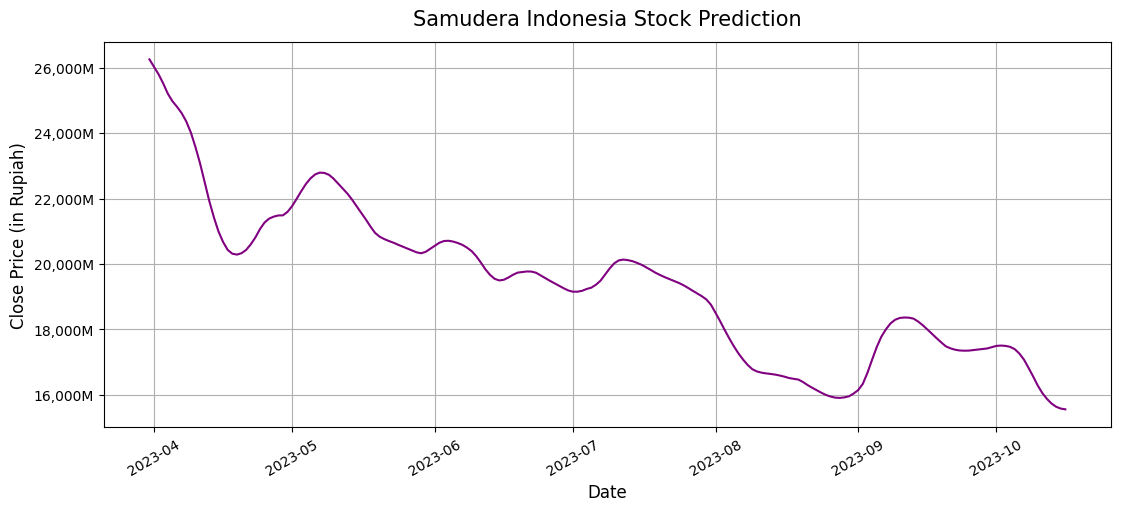

In [95]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_smdr.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='purple')
plt.title('Samudera Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [96]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
import time
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 63ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 56ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 55ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 47ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 49ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 58ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 56ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 53ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 49ms/step
Training

In [97]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta               133.69  1.91865   0.88797  3.83897   
           adagrad                174.91  1.95005   0.89995  3.99021   
           adam                   151.89  0.22008   0.09608  0.07714   
           adamax                 136.89  0.26169   0.11469  0.10431   
           nadam                  179.74  0.26598   0.11879  0.09889   
           rmsprop                131.17  0.34986   0.14945  0.19096   
           sgd                    138.41  1.28945   0.59029  1.78693   
relu       adadelta               100.73  2.00555   0.92828  4.19231   
           adagrad                111.88  1.90988   0.88188  3.82316   
           adam                   106.88  0.34689   0.15629  0.15354   
           adamax                 114.02  0.31777   0.13917  0.14831   
           nadam                  117.03  0.35895   0.16027  0.16505   
           rmsprop                100.44  0.59133   0.26181  0.43349   
           sgd                    104.72  1.83105   0.84372  3.53071   
sigmoid    adadelta               135.05  2.58119   1.20427  6.83421   
           adagrad                132.36  1.94101   0.89585  3.95157   
           adam                   131.85  1.47943   0.67511  2.36576   
           adamax                 134.52  1.58620   0.72638  2.69271   
           nadam                  133.51  0.89559   0.40151  0.92333   
           rmsprop                132.84  1.65576   0.75983  2.91734   
           sgd                    134.97  1.89713   0.87623  3.76932   
tanh       adadelta               141.69  2.25240   1.04440  5.26518   
           adagrad                149.07  2.01891   0.93312  4.26111   
           adam                   111.14  0.41964   0.18438  0.22845   
           adamax                 132.38  0.37743   0.16637  0.19161   
           nadam                  147.32  0.51207   0.22998  0.30900   
           rmsprop                139.02  0.40881   0.17575  0.24315   
           sgd                    132.89  1.59967   0.73620  2.70657   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   4.529677e-05         -20.32   1.95933     0.968905  
           adagrad    3.495204e-16         -21.16   1.99755     0.813622  
           adam       5.965894e-10           0.57   0.27774     0.920911  
           adamax     8.245937e-11           0.42   0.32297     0.909619  
           nadam      1.610903e-10           0.45   0.31447     0.913549  
           rmsprop    2.161961e-05          -0.06   0.43699     0.966470  
           sgd        1.470268e-04          -8.93   1.33676     0.972604  
relu       adadelta   2.104448e-04         -22.29   2.04751     0.973690  
           adagrad    2.520757e-03         -20.24   1.95529     0.980726  
           adam       2.950016e-10           0.15   0.39184     0.917003  
           adamax     6.678463e-08           0.18   0.38511     0.944145  
           nadam      1.106764e-09           0.08   0.40626     0.924241  
           rmsprop    2.199970e-05          -1.41   0.65840     0.966528  
           sgd        1.315172e-06         -18.61   1.87902     0.956423  
sigmoid    adadelta   1.414810e-04         -36.96   2.61423     0.972487  
           adagrad    7.557498e-09         -20.95   1.98786     0.934028  
           adam       2.135723e-05         -12.14   1.53810     0.966429  
           adamax     1.693153e-04         -13.96   1.64095     0.973034  
           nadam      5.430156e-07          -4.13   0.96090     0.952957  
           rmsprop    1.098647e-03         -15.20   1.70802     0.978462  
           sgd        2.467771e-04         -19.94   1.94147     0.974166  
tanh       adadelta   2.010821e-04         -28.25   2.29460     0.973553  
           adagrad    1.091786e-08         -22.67   2.06425  

In [98]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adam                   151.89  0.22008   0.09608  0.07714   
           adamax                 136.89  0.26169   0.11469  0.10431   
           nadam                  179.74  0.26598   0.11879  0.09889   
relu       adamax                 114.02  0.31777   0.13917  0.14831   
linear     rmsprop                131.17  0.34986   0.14945  0.19096   
relu       adam                   106.88  0.34689   0.15629  0.15354   
           nadam                  117.03  0.35895   0.16027  0.16505   
tanh       adamax                 132.38  0.37743   0.16637  0.19161   
           rmsprop                139.02  0.40881   0.17575  0.24315   
           adam                   111.14  0.41964   0.18438  0.22845   
           nadam                  147.32  0.51207   0.22998  0.30900   
relu       rmsprop                100.44  0.59133   0.26181  0.43349   
sigmoid    nadam                  133.51  0.89559   0.40151  0.92333   
linear     sgd                    138.41  1.28945   0.59029  1.78693   
sigmoid    adam                   131.85  1.47943   0.67511  2.36576   
           adamax                 134.52  1.58620   0.72638  2.69271   
tanh       sgd                    132.89  1.59967   0.73620  2.70657   
sigmoid    rmsprop                132.84  1.65576   0.75983  2.91734   
relu       sgd                    104.72  1.83105   0.84372  3.53071   
sigmoid    sgd                    134.97  1.89713   0.87623  3.76932   
relu       adagrad                111.88  1.90988   0.88188  3.82316   
linear     adadelta               133.69  1.91865   0.88797  3.83897   
sigmoid    adagrad                132.36  1.94101   0.89585  3.95157   
linear     adagrad                174.91  1.95005   0.89995  3.99021   
relu       adadelta               100.73  2.00555   0.92828  4.19231   
tanh       adagrad                149.07  2.01891   0.93312  4.26111   
           adadelta               141.69  2.25240   1.04440  5.26518   
sigmoid    adadelta               135.05  2.58119   1.20427  6.83421   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adam       5.965894e-10           0.57   0.27774     0.920911  
           adamax     8.245937e-11           0.42   0.32297     0.909619  
           nadam      1.610903e-10           0.45   0.31447     0.913549  
relu       adamax     6.678463e-08           0.18   0.38511     0.944145  
linear     rmsprop    2.161961e-05          -0.06   0.43699     0.966470  
relu       adam       2.950016e-10           0.15   0.39184     0.917003  
           nadam      1.106764e-09           0.08   0.40626     0.924241  
tanh       adamax     3.265485e-09          -0.06   0.43773     0.929856  
           rmsprop    3.718553e-05          -0.35   0.49310     0.968264  
           adam       3.981306e-08          -0.27   0.47796     0.941834  
           nadam      1.926605e-09          -0.72   0.55588     0.927152  
relu       rmsprop    2.199970e-05          -1.41   0.65840     0.966528  
sigmoid    nadam      5.430156e-07          -4.13   0.96090     0.952957  
linear     sgd        1.470268e-04          -8.93   1.33676     0.972604  
sigmoid    adam       2.135723e-05         -12.14   1.53810     0.966429  
           adamax     1.693153e-04         -13.96   1.64095     0.973034  
tanh       sgd        5.878934e-04         -14.03   1.64517     0.976700  
sigmoid    rmsprop    1.098647e-03         -15.20   1.70802     0.978462  
relu       sgd        1.315172e-06         -18.61   1.87902     0.956423  
sigmoid    sgd        2.467771e-04         -19.94   1.94147     0.974166  
relu       adagrad    2.520757e-03         -20.24   1.95529     0.980726  
linear     adadelta   4.529677e-05         -20.32   1.95933     0.968905  
sigmoid    adagrad    7.557498e-09         -20.95   1.98786  

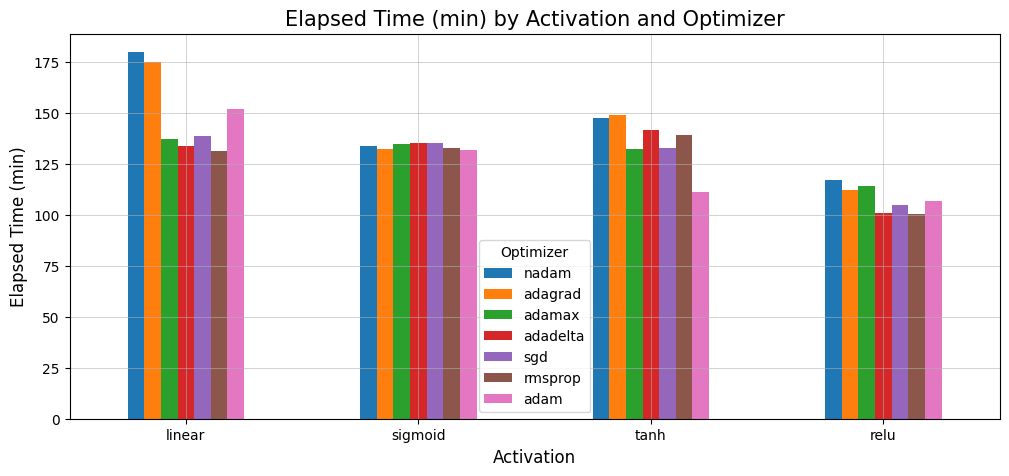

In [99]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

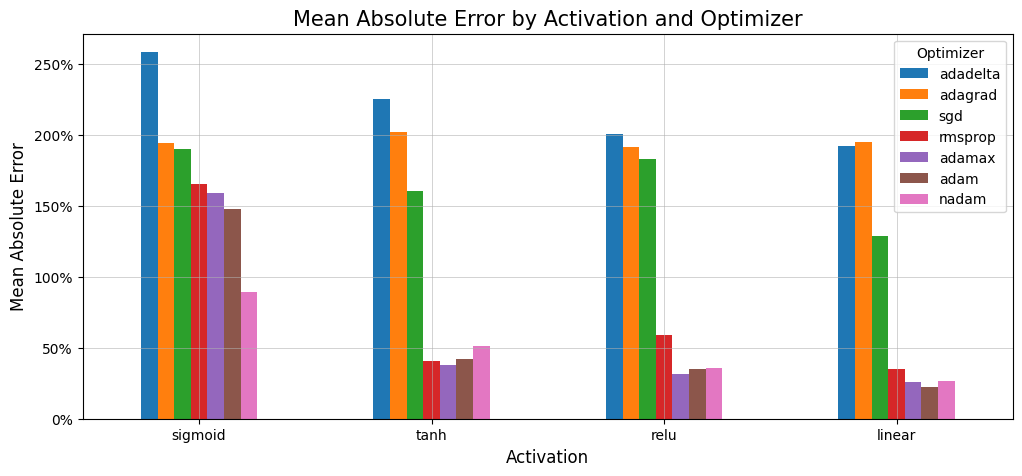

In [100]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

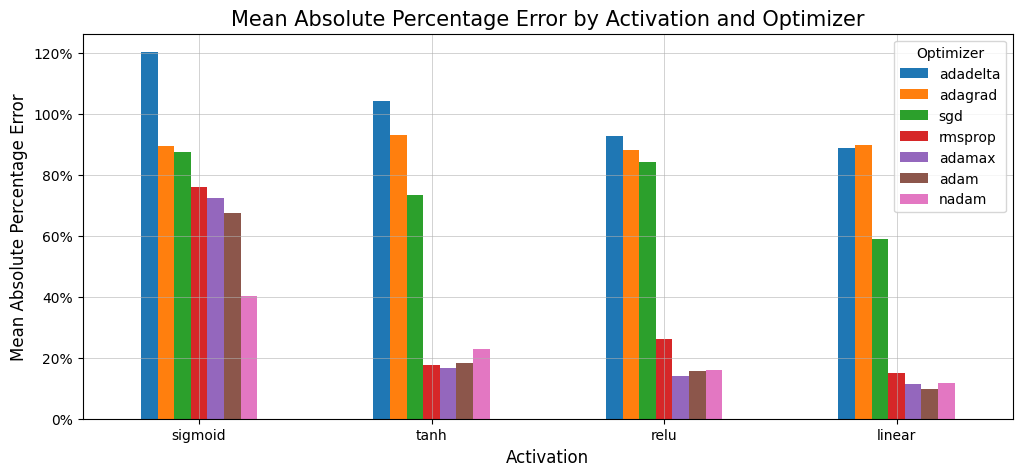

In [101]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

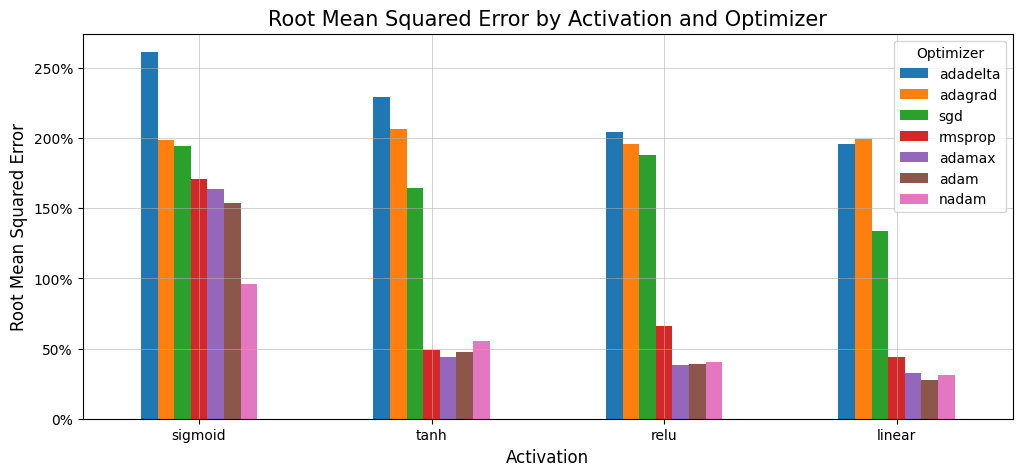

In [102]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

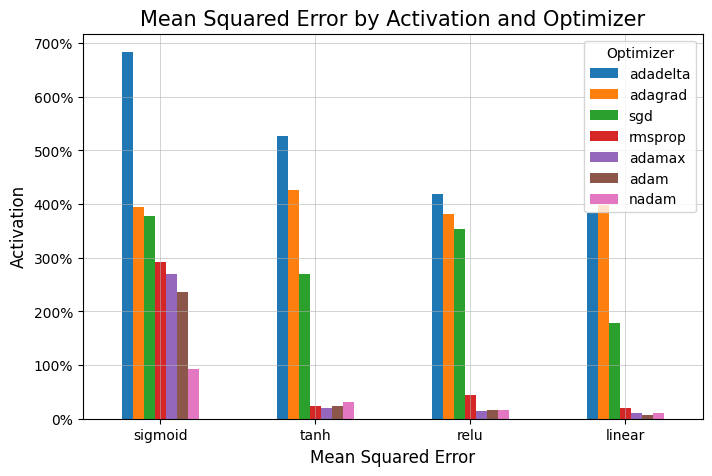

In [103]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=False)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Activation', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

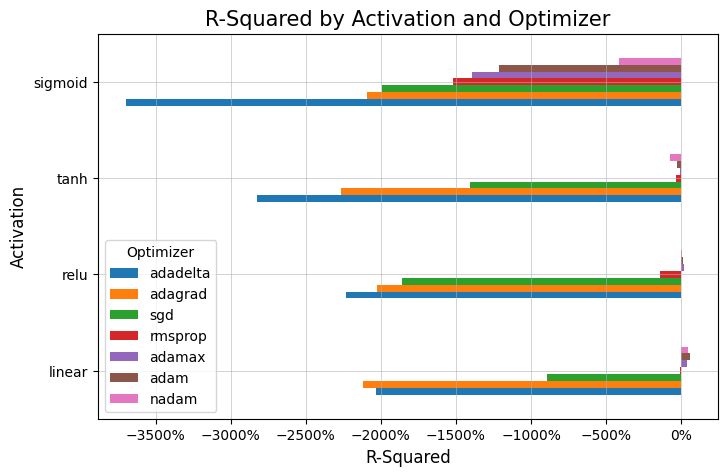

In [104]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()